In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [ ]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )

    #count missing values in X
    missing_values_count = X.isnull().sum().sum()
    print(f"Missing values in X: {missing_values_count}")

    X = np.array(X)
    y = np.array(y)[..., None]
    print(X.shape)
    print(y.shape)
    
    # Determine if the dataset has categorical features
    has_categorical = any(categorical_indicator)
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
        'has_categorical': has_categorical,
        'n_missing_values': missing_values_count,
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
df_metadata.sort_values('%_unique_y', ascending=True)

# Display the metadata DataFrame
df_metadata.loc[44962, "has_categorical"] = True
df_metadata

In [ ]:
from optuna_kfoldCV import np_load_openml_dataset, openML_reg_ids
import numpy as np

for id in openML_reg_ids:
    X,y = np_load_openml_dataset(id, "regression")
    print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# for id in df_metadata.index:
#     X,y = np_load_openml_dataset(id, "regression")
#     print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# Run experiments (just for testing)

In [ ]:
# !python regression_param_specs.py \
#     --models End2End \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models Ridge \
#     --dataset_indices 10 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 100 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models XGBoostRegressor \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
!python regression_param_specs.py \
    --models GradientRFRBoost_upscaleiid \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

In [ ]:
!python regression_param_specs.py \
    --models GradientRFRBoost_upscaleiid_iidfeat \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GradientRFRBoostID \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostDense \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostDiag \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostScalar \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models RandomFeatureNetwork \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

# join json results

In [4]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_reg_ids,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [5]:
for i in range(35):
    for model in ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ]:
        try:
            results = results_to_df(models=[model], datasets=[openML_reg_ids[i]])
            # print(results)
        except:
            print(f"Failed for {model} on {i}, ie {openML_reg_ids[i]}")
            pass

In [29]:
# df = results_to_df(        
#     datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
#     save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
#     )
df = results_to_df(        
    models = ["End2End", "Ridge", "XGBoostRegressor", 
                "GradientRFRBoost", "GradientRFRBoostID", 
                #"GradientRFRBoost_relu",
                "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                #"GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                "RandomFeatureNetwork", 
                #"RandomFeatureNetwork_iid",
                #"RandomFeatureNetwork_relu", 
                #"RandomFeatureNetwork_iid_relu",
                ],
    datasets = openML_reg_ids[:],
    save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
    )

In [30]:
df["score_test"].mean().sort_values(ascending=True)
# GradientRFRBoost_upscaleiid        0.409032
# End2End                              0.4101
# GreedyRFRBoostDense_upscaleiid     0.411854
# GreedyRFRBoostDiag_upscaleiid       0.43373
# GreedyRFRBoostScalar_upscaleiid    0.456377
# RandomFeatureNetwork_iid           0.494089
# Ridge                              0.529513
# dtype: object

XGBoostRegressor        0.376724
GradientRFRBoost        0.406472
GreedyRFRBoostDense     0.407158
End2End                   0.4089
GradientRFRBoostID      0.412796
GreedyRFRBoostDiag      0.420843
RandomFeatureNetwork    0.424886
GreedyRFRBoostScalar    0.456615
Ridge                   0.529513
dtype: object

In [31]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor        0.192556
End2End                 0.301066
GradientRFRBoost         0.35233
GreedyRFRBoostDense     0.353879
GradientRFRBoostID      0.360142
GreedyRFRBoostDiag      0.371691
RandomFeatureNetwork    0.392703
GreedyRFRBoostScalar     0.41543
Ridge                   0.522192
dtype: object

In [32]:
df["score_test"].rank(axis=1).mean().sort_values()
# GradientRFRBoost_upscaleiid        2.400000
# GreedyRFRBoostDense_upscaleiid     2.400000
# End2End                            3.542857
# GreedyRFRBoostDiag_upscaleiid      3.685714
# GreedyRFRBoostScalar_upscaleiid    4.657143
# RandomFeatureNetwork_iid           5.371429
# Ridge                              5.942857
# dtype: float64

XGBoostRegressor        2.685714
GradientRFRBoost        3.371429
GreedyRFRBoostDense     3.542857
GradientRFRBoostID      4.657143
RandomFeatureNetwork    5.000000
End2End                 5.057143
GreedyRFRBoostDiag      5.428571
GreedyRFRBoostScalar    7.257143
Ridge                   8.000000
dtype: float64

In [33]:
#number of first places
(df["score_test"].rank(axis=1) == 1).sum().sort_values()
# GreedyRFRBoostScalar_upscaleiid     0
# RandomFeatureNetwork_iid            1
# GreedyRFRBoostDiag_upscaleiid       2
# Ridge                               5
# GreedyRFRBoostDense_upscaleiid      6
# End2End                             9
# GradientRFRBoost_upscaleiid        12
# dtype: int64

GreedyRFRBoostDiag       0
GreedyRFRBoostScalar     0
GradientRFRBoostID       1
GreedyRFRBoostDense      1
Ridge                    2
End2End                  3
RandomFeatureNetwork     3
GradientRFRBoost         4
XGBoostRegressor        21
dtype: int64

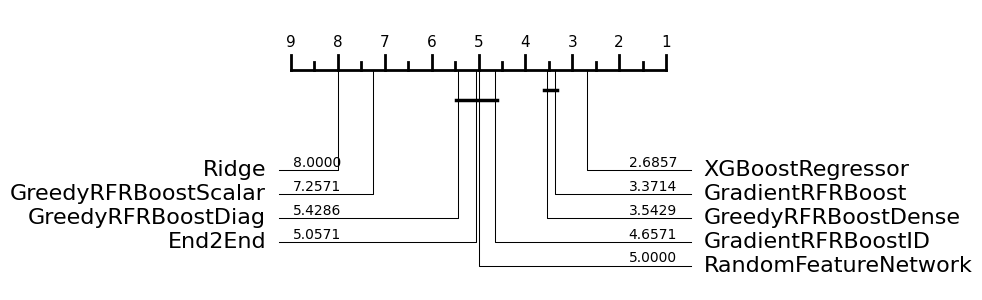

In [34]:
def auc_df_to_aeonresults(auc_df):
    return (auc_df.values, auc_df.columns.tolist())

from aeon.visualisation import plot_critical_difference, plot_significance


results = auc_df_to_aeonresults(df["score_test"])
plot = plot_critical_difference(results[0], results[1], alpha=0.05, lower_better=True)

In [23]:
# df2 = results_to_df(        
#     datasets = openML_reg_ids_noCat[[0,1,2  ,4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
#     save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
#     )

In [ ]:
# df2["score_test"].mean().sort_values(ascending=True)

In [ ]:
# df2["score_train"].mean().sort_values(ascending=True)

In [ ]:
# df2["score_test"].rank(axis=1).mean().sort_values()

In [ ]:
#number of first places
# (df2["score_test"].rank(axis=1) == 1).sum().sort_values()

In [ ]:
# XGBoostRegressor       0.389427
# End2End                0.408184
# GreedyRFBoostDense      0.43249
# GradientRFBoost        0.434696
# GradientRFBoostID      0.436364
# GreedyRFBoostDiag      0.445675
# GreedyRFBoostScalar    0.528314
# Ridge                  0.606384
# RidgeCV                0.606385
# dtype: object


# XGBoostRegressor       0.170585
# End2End                0.345058
# GreedyRFBoostDense     0.387421
# GradientRFBoost        0.400575
# GradientRFBoostID      0.405132
# GreedyRFBoostDiag       0.41455
# GreedyRFBoostScalar    0.510962
# RidgeCV                0.600331
# Ridge                   0.60034
# dtype: object


# XGBoostRegressor       2.666667
# End2End                3.333333
# GreedyRFBoostDense     3.500000
# GradientRFBoost        3.611111
# GradientRFBoostID      4.111111
# GreedyRFBoostDiag      4.777778
# GreedyRFBoostScalar    6.722222
# Ridge                  8.055556
# RidgeCV                8.222222
# dtype: float64


# Ridge                   0
# RidgeCV                 0
# GradientRFBoostID       0
# GreedyRFBoostScalar     0
# GradientRFBoost         1
# GreedyRFBoostDense      1
# GreedyRFBoostDiag       1
# End2End                 4
# XGBoostRegressor       11
# dtype: int64

# Look at small datasets

In [12]:
less5000 = df_metadata.query("n_obs < 5000").index
less1000 = df_metadata.query("n_obs < 1000").index
less5000

NameError: name 'df_metadata' is not defined

In [ ]:
df["score_test"].loc[less5000].mean().sort_values(ascending=True)

In [ ]:
df["score_test"].loc[less5000].rank(axis=1).mean().sort_values(ascending=True)

In [ ]:
df["score_test"].loc[less5000].rank(axis=1)

In [ ]:
df["score_test"].loc[less1000]

# Look at distribution of params

Model: End2End


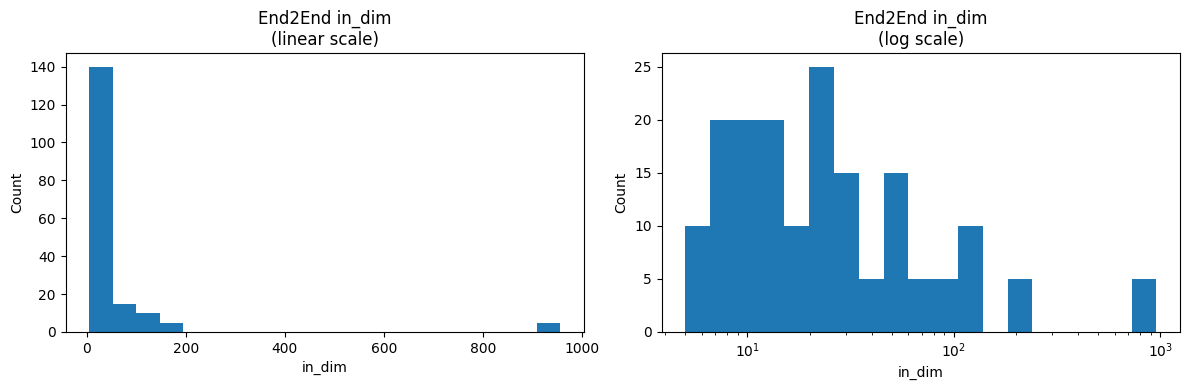

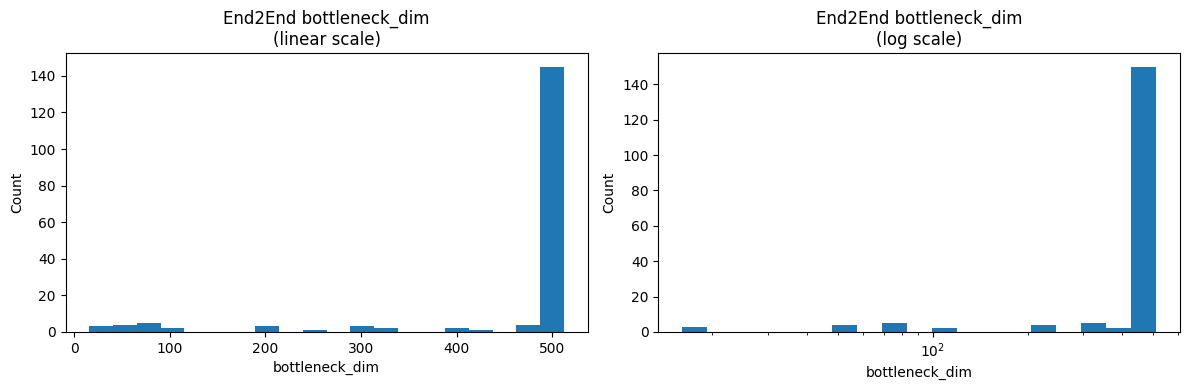

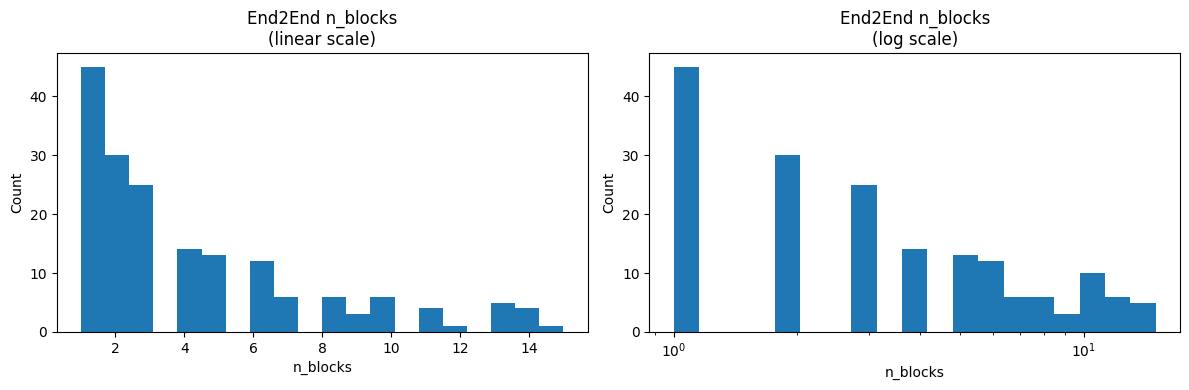

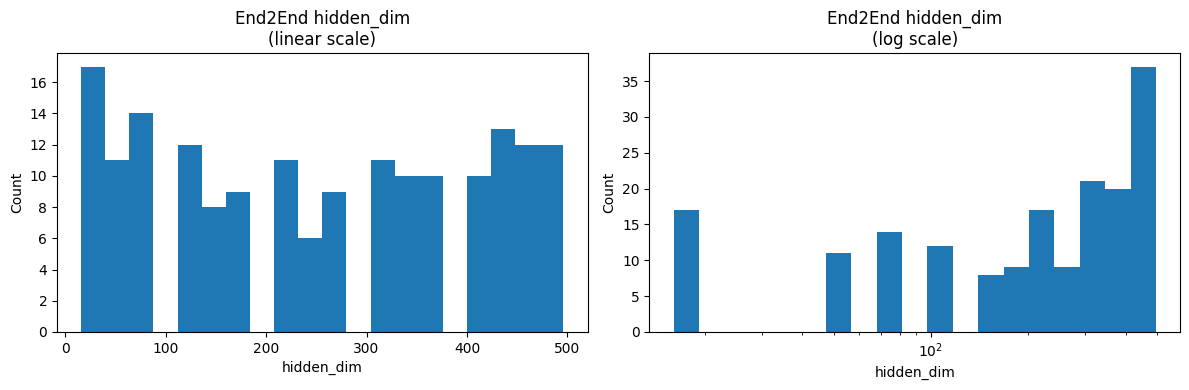

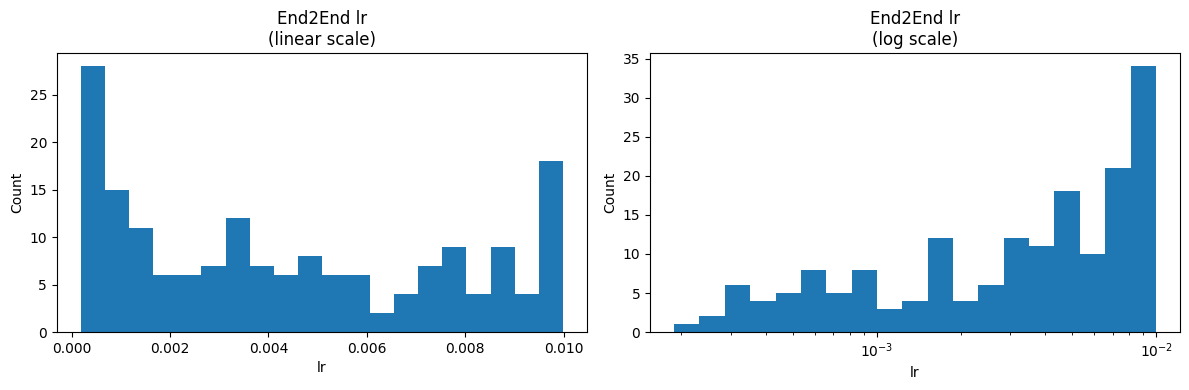

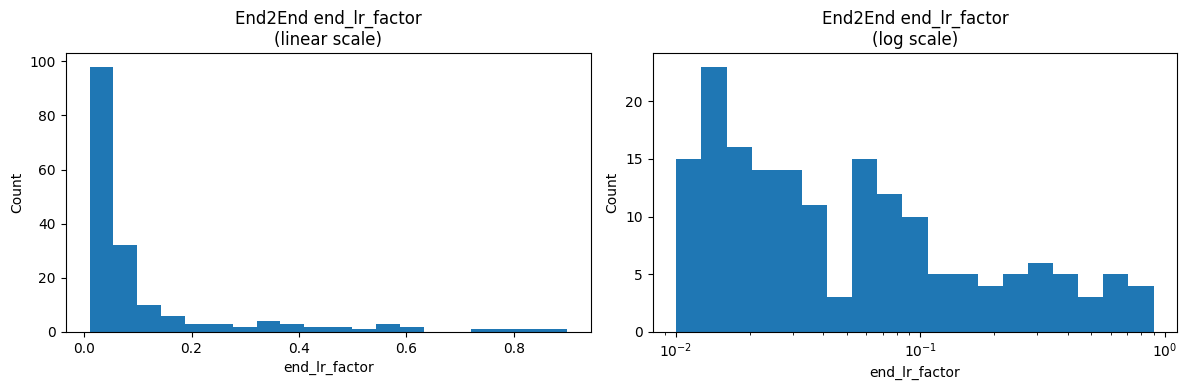

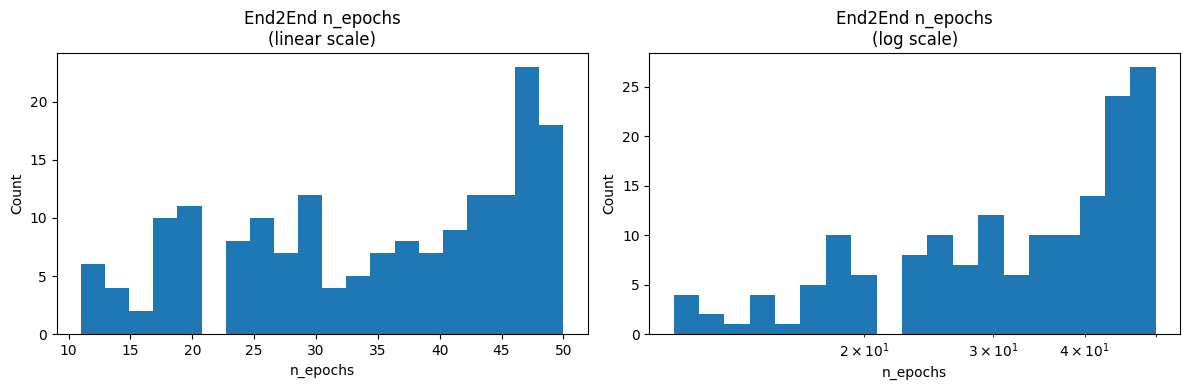

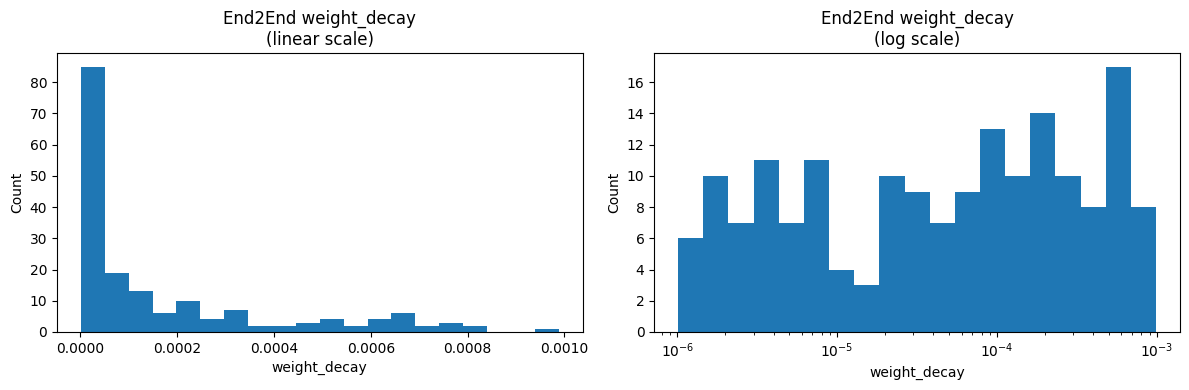

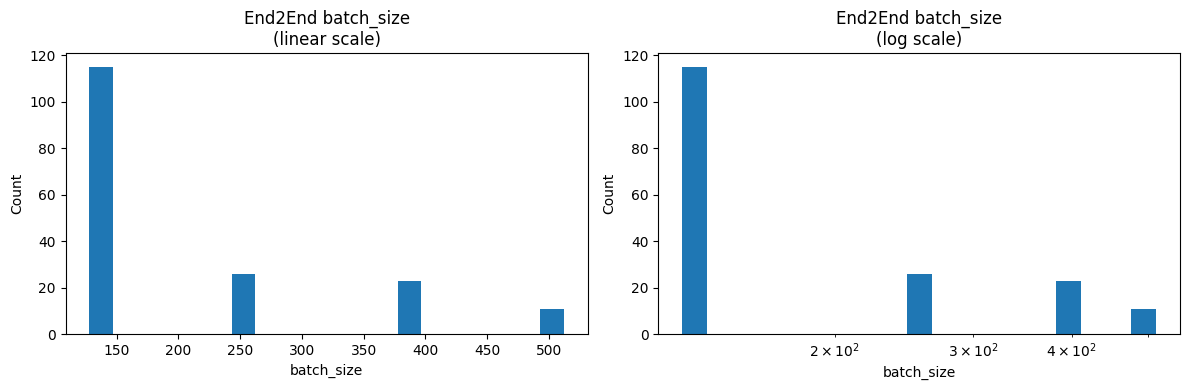

Model: Ridge


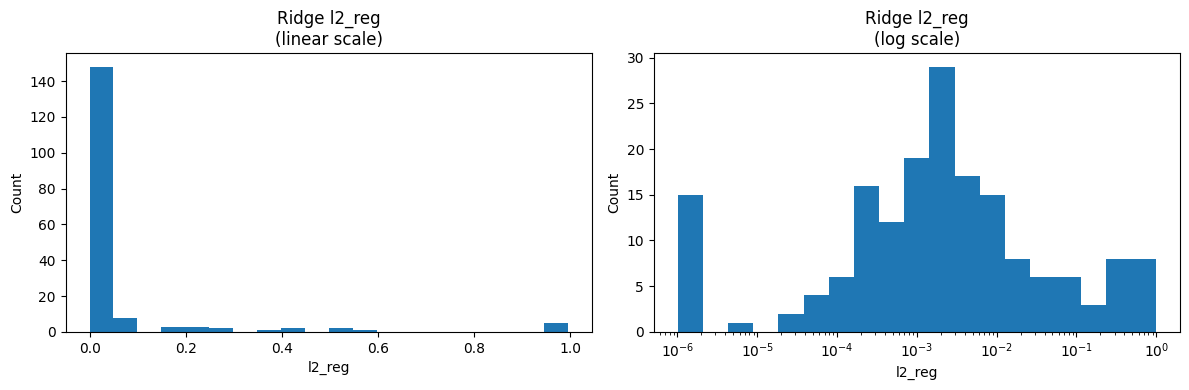

Model: XGBoostRegressor


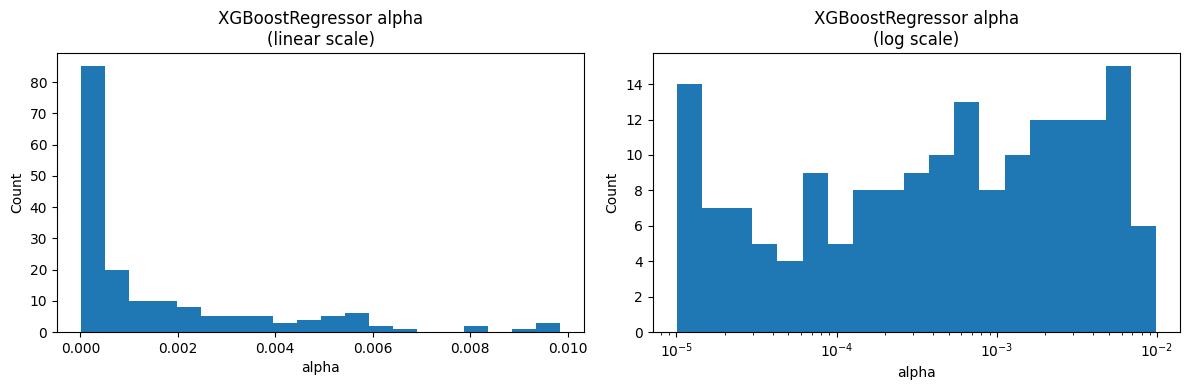

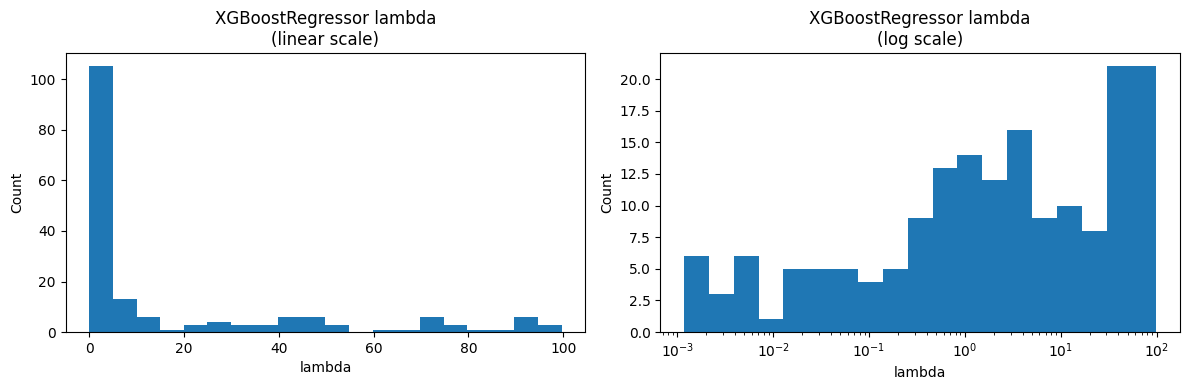

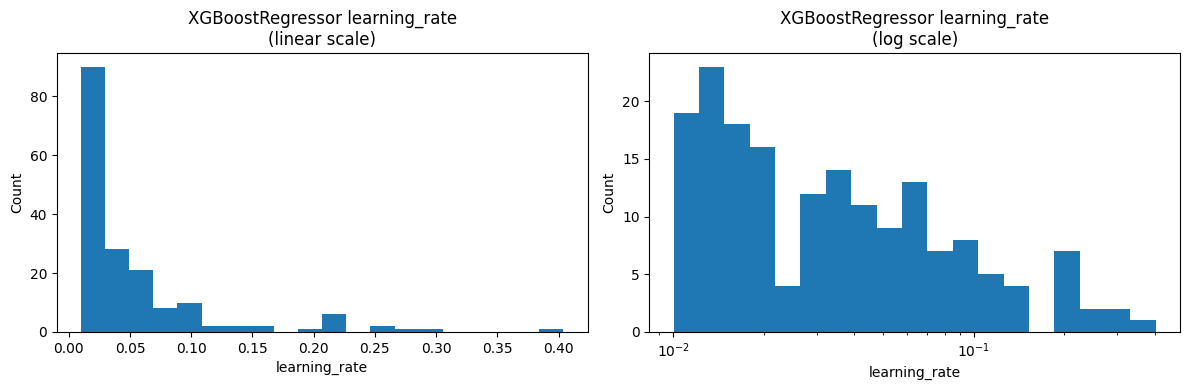

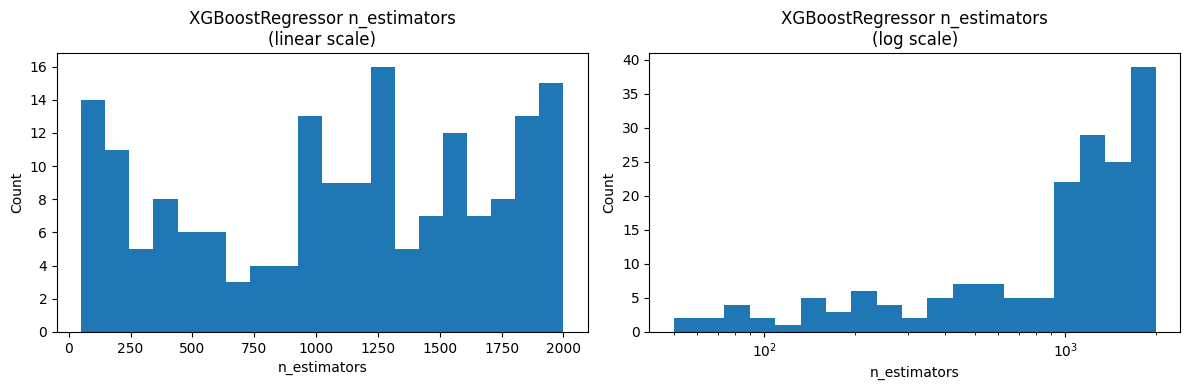

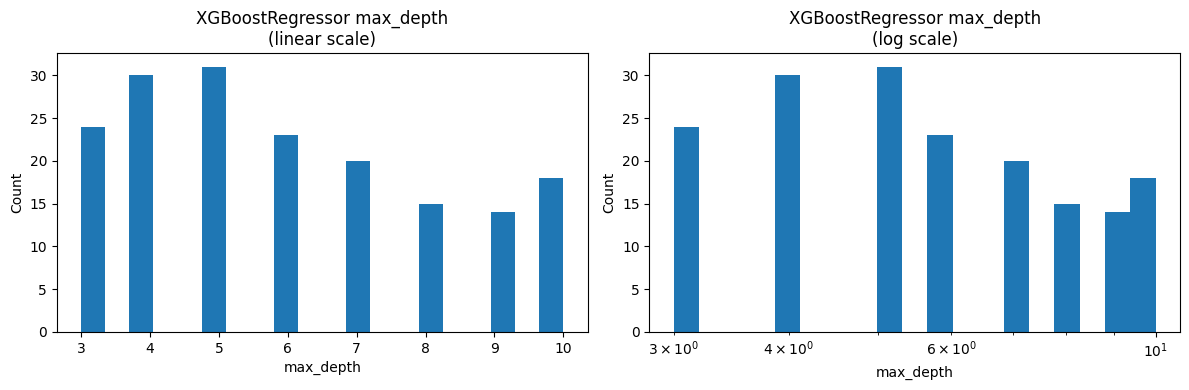

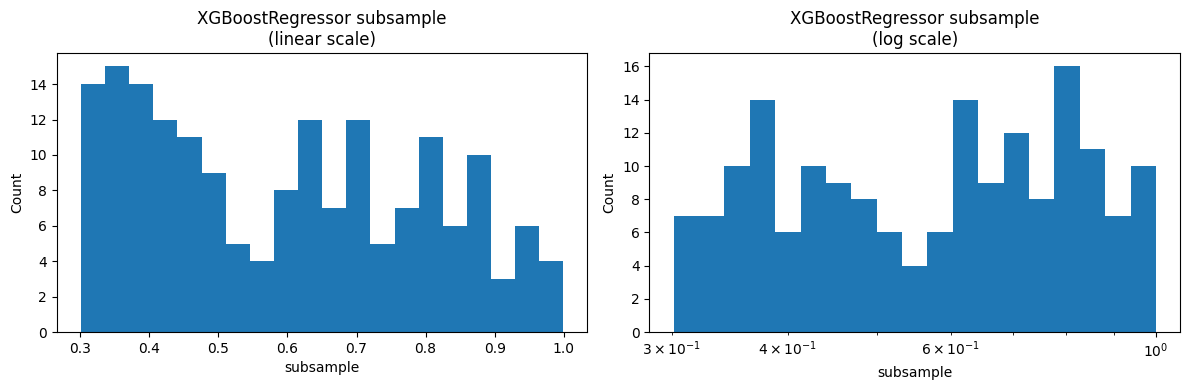

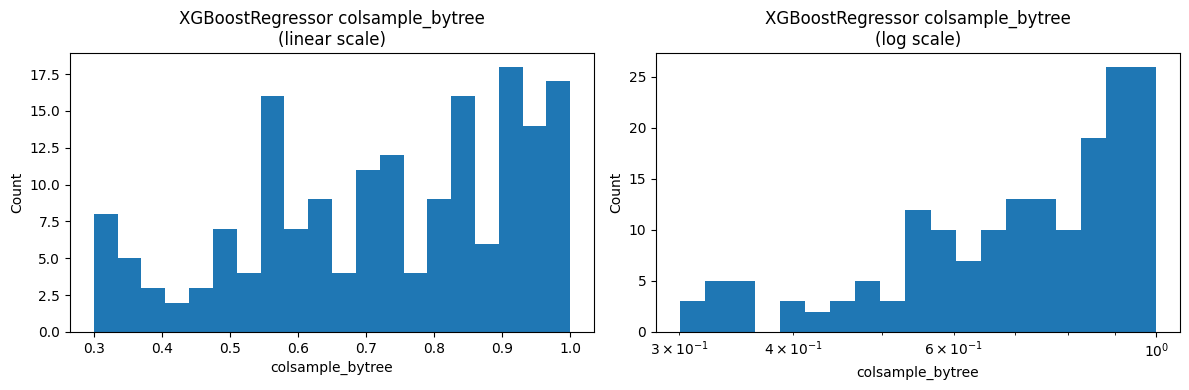

Model: GradientRFRBoost


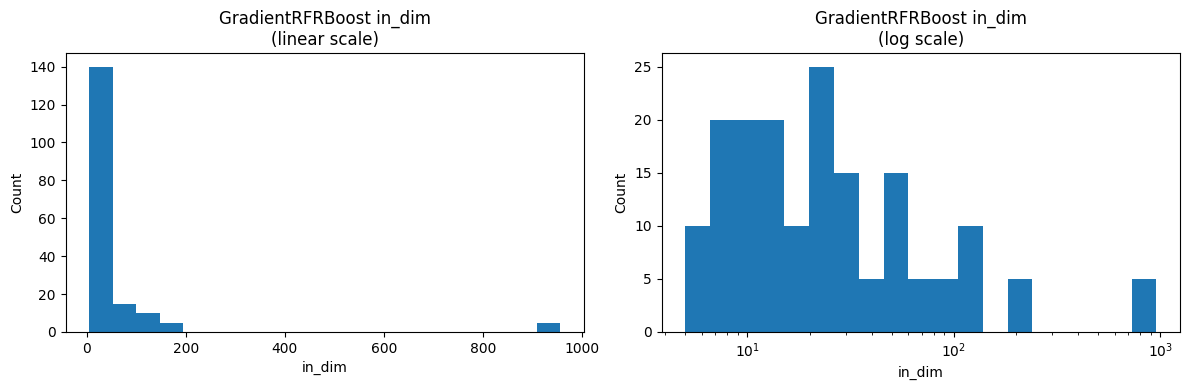

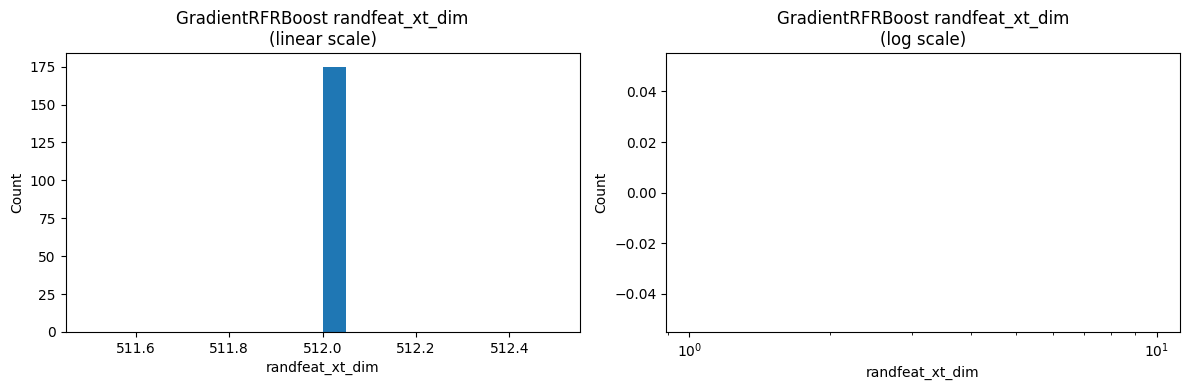

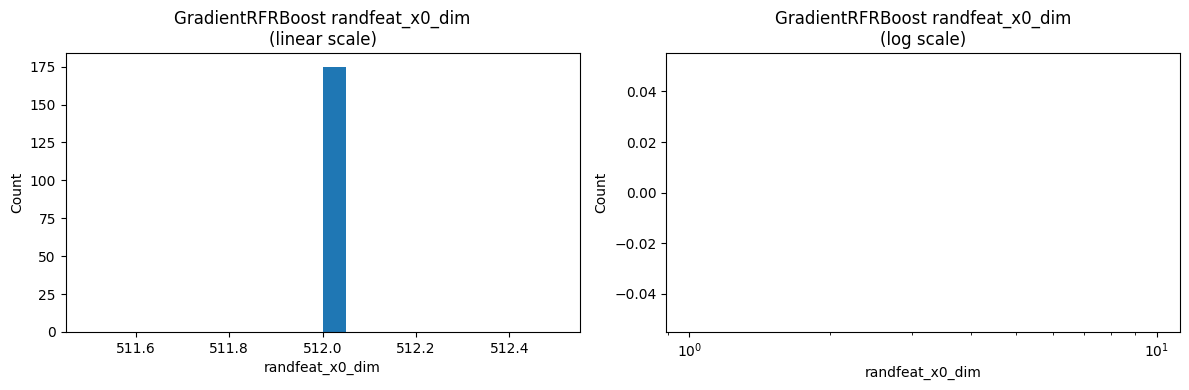

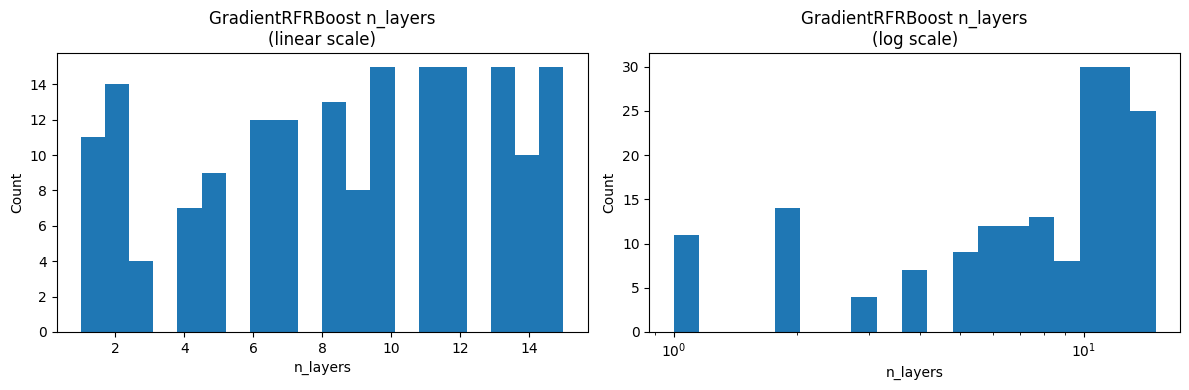

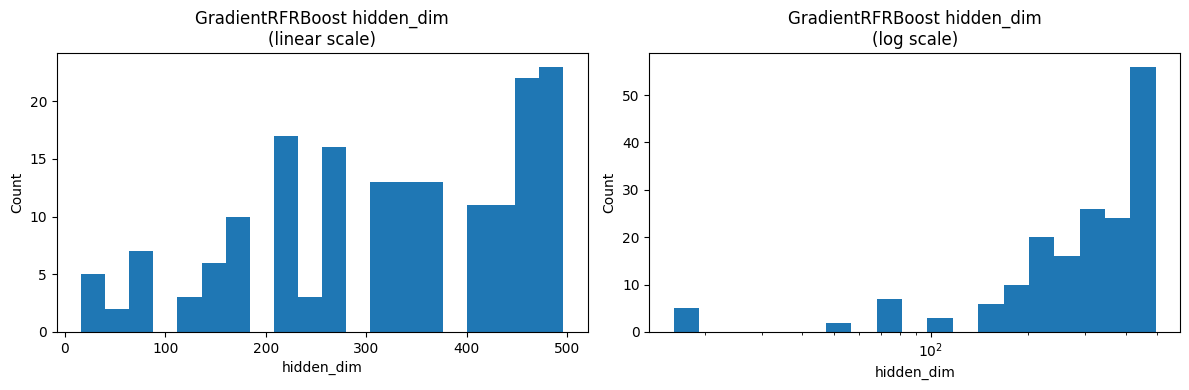

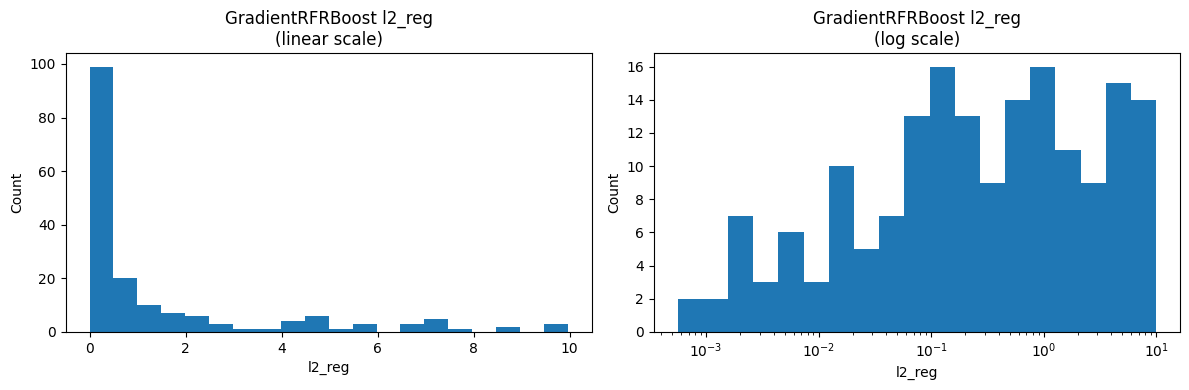

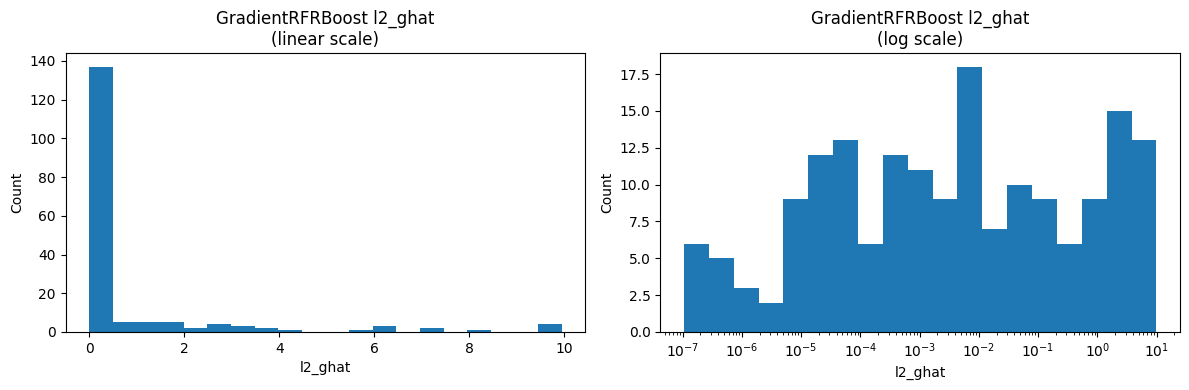

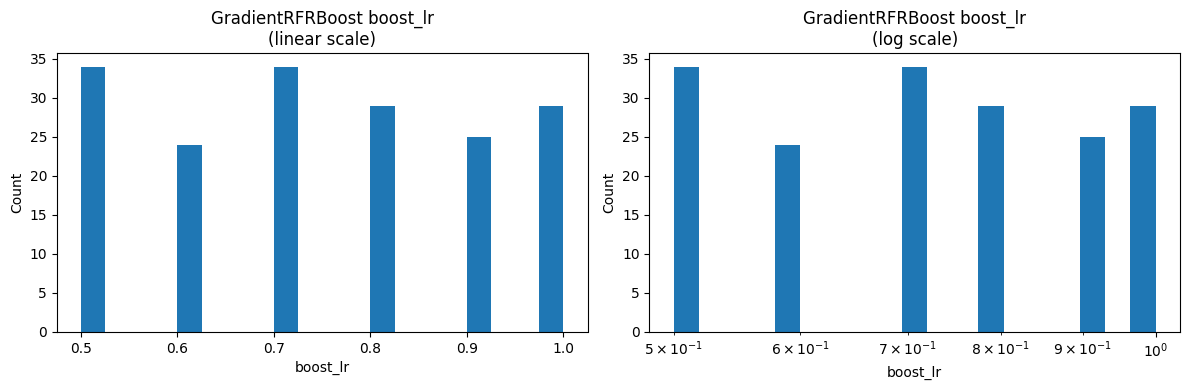

/tmp/ipykernel_22160/3327890562.py:54: RuntimeWarning: invalid value encountered in log10
  bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)


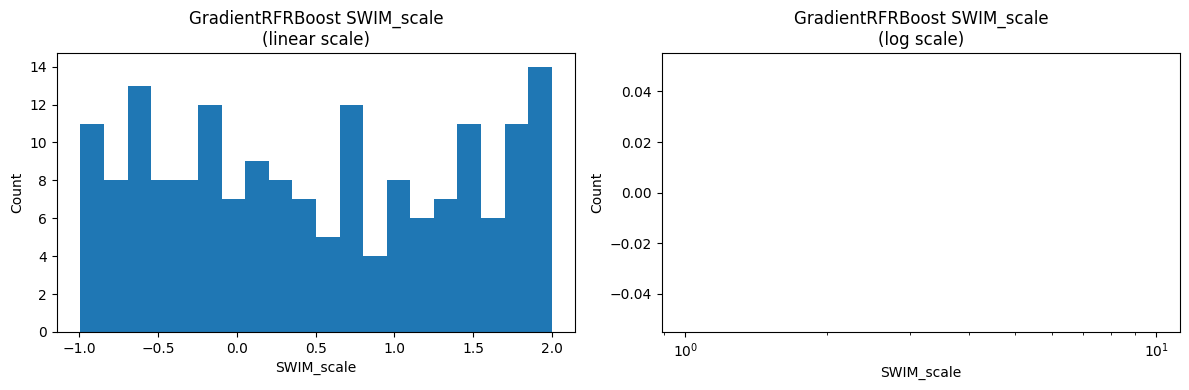

Model: GradientRFRBoostID


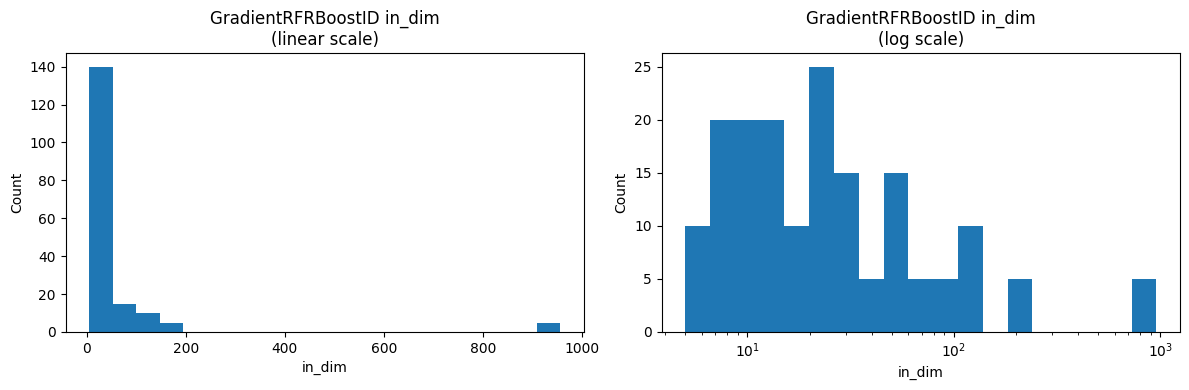

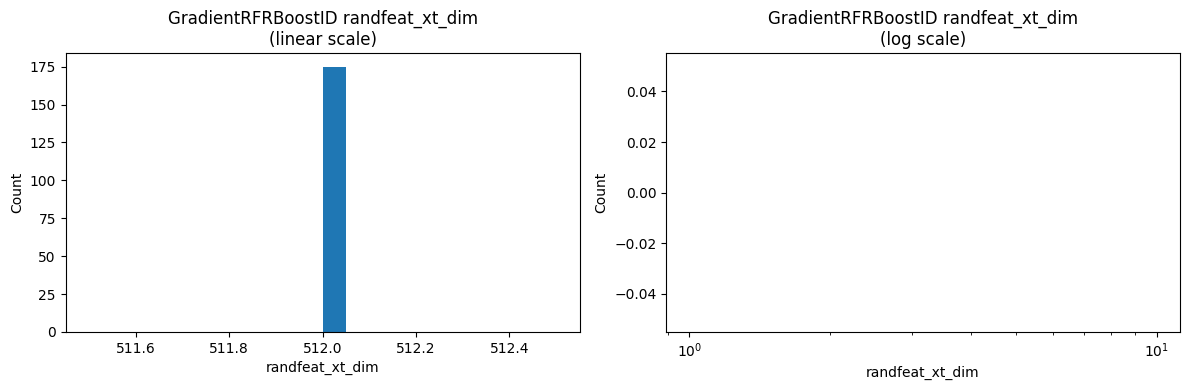

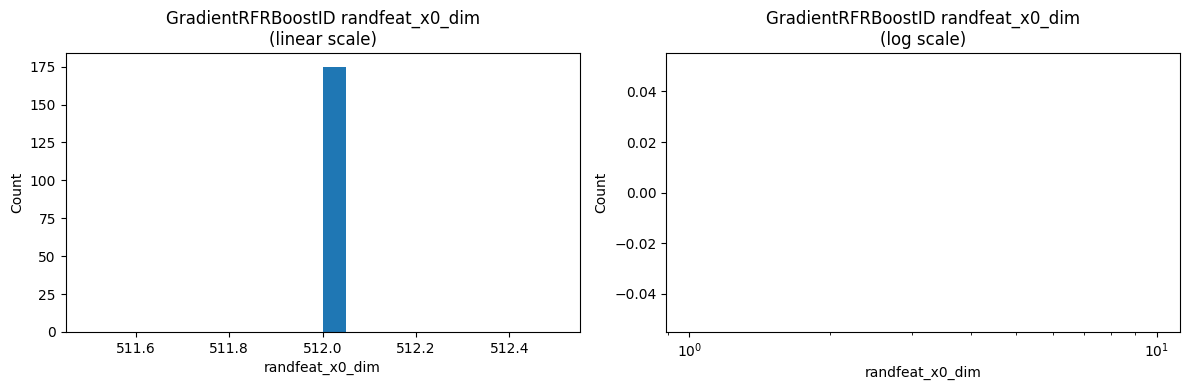

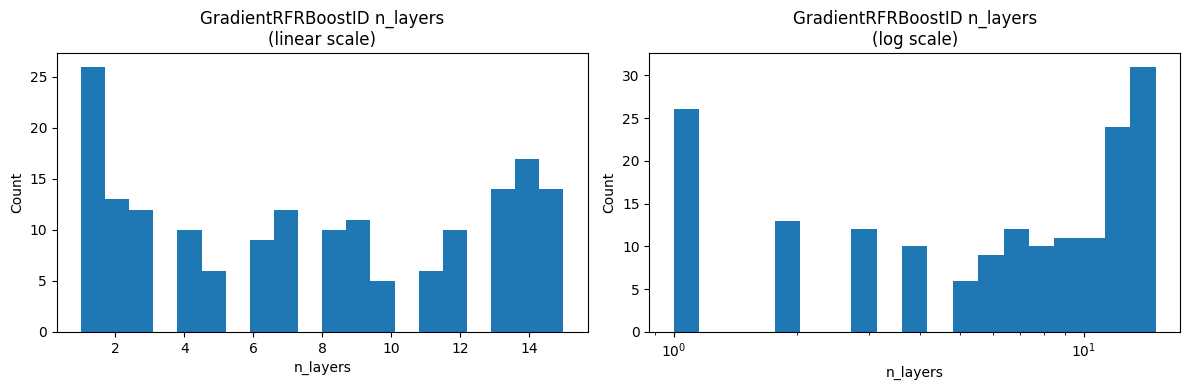

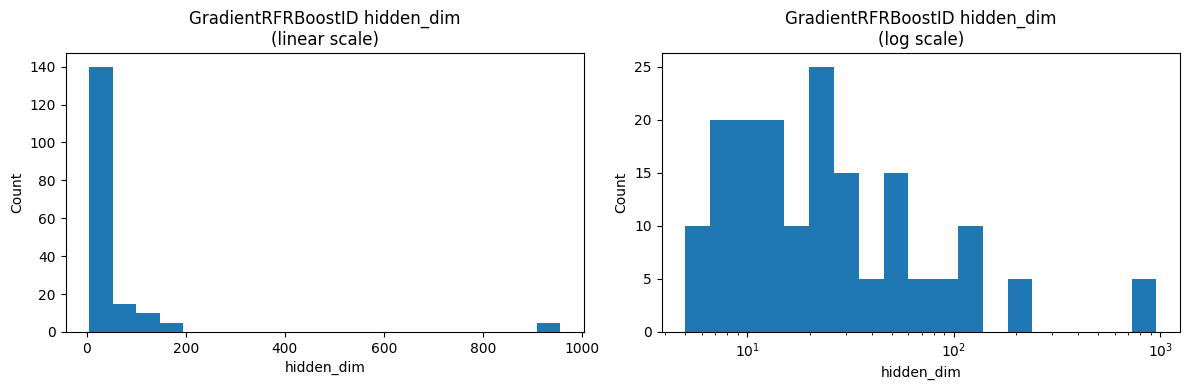

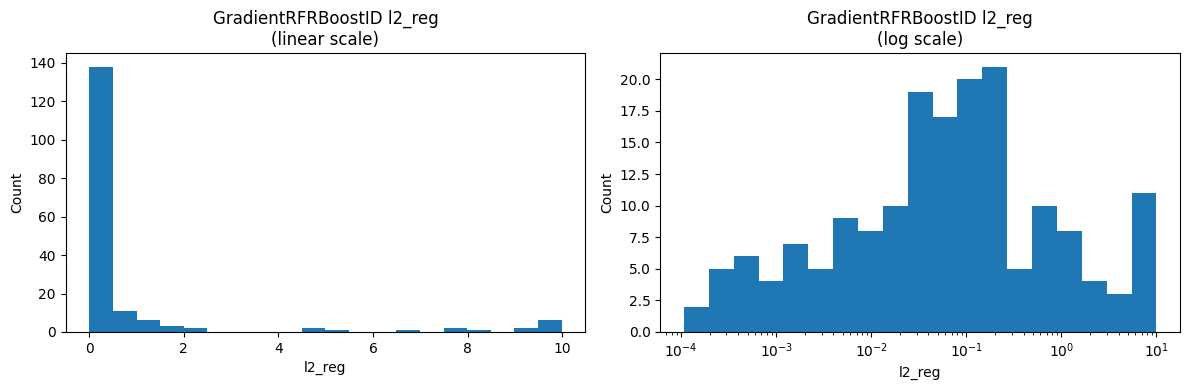

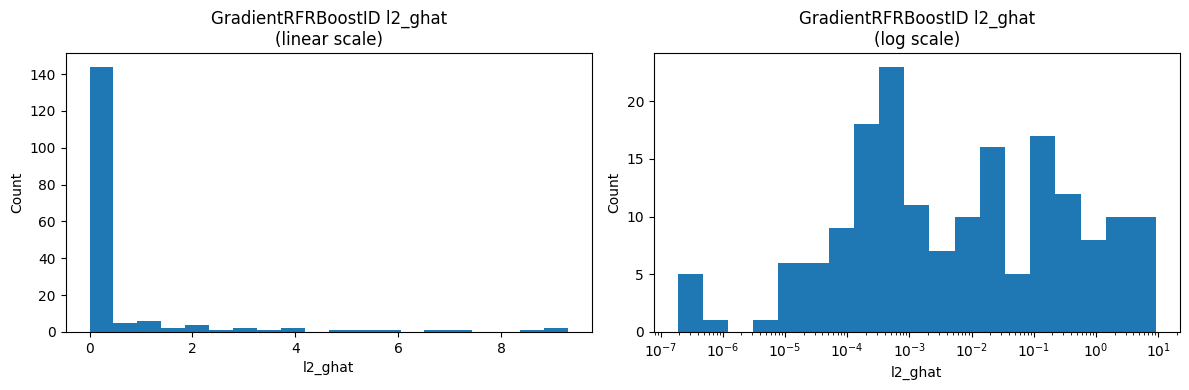

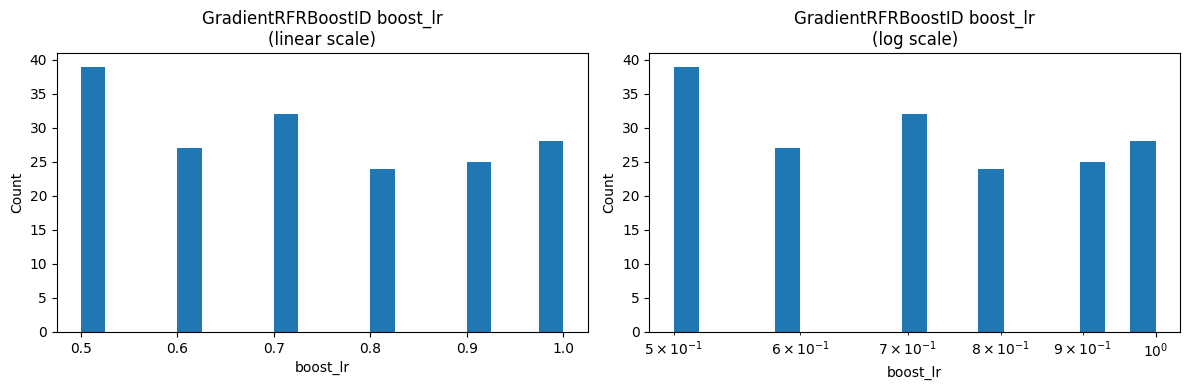

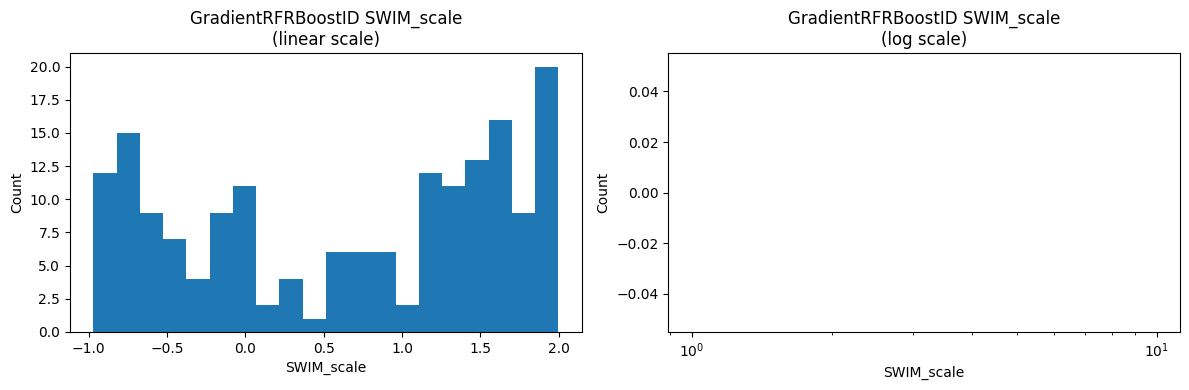

Model: GradientRFRBoost_relu


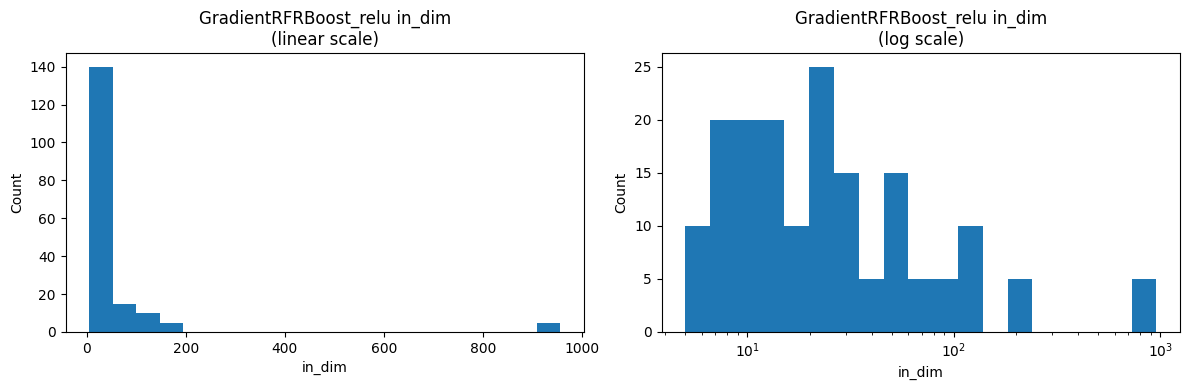

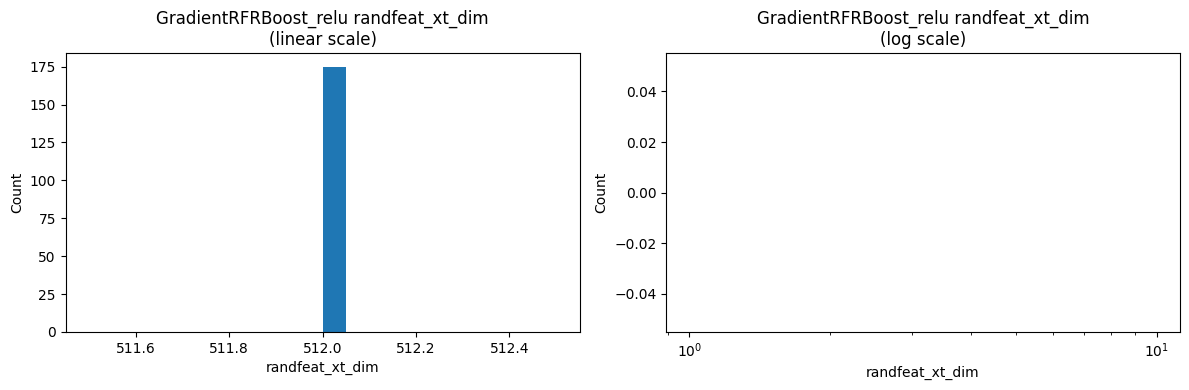

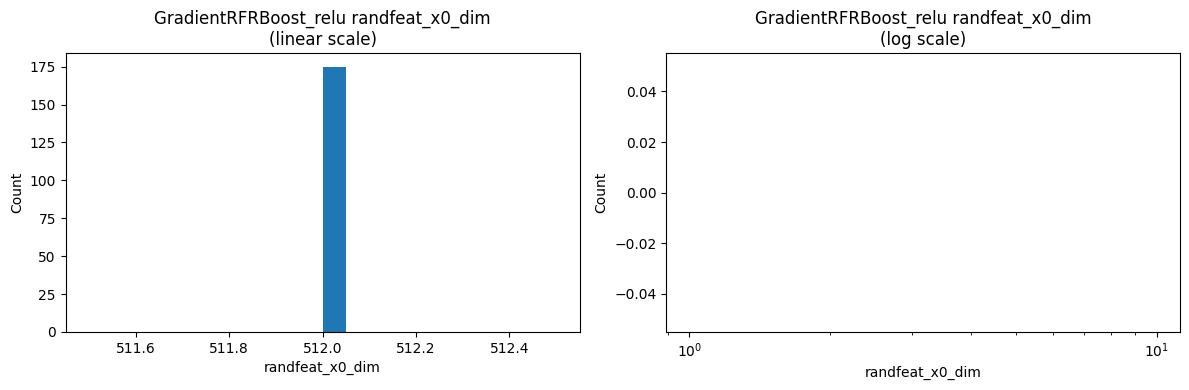

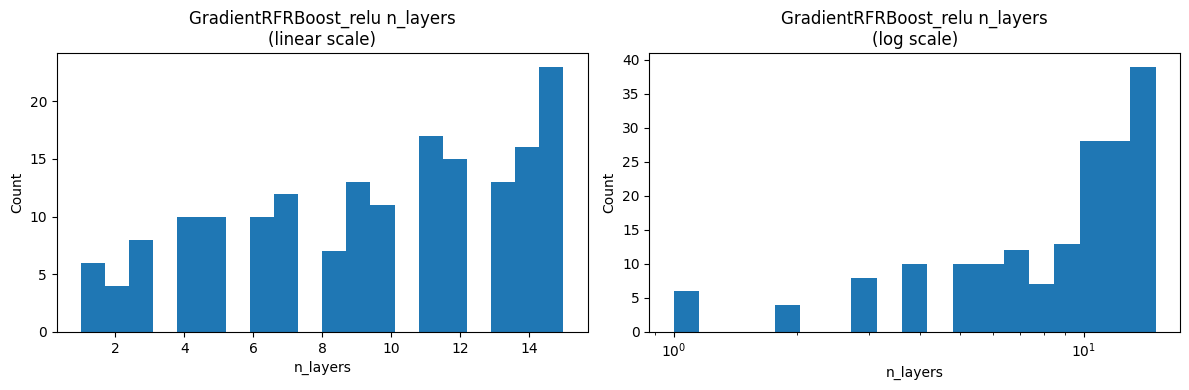

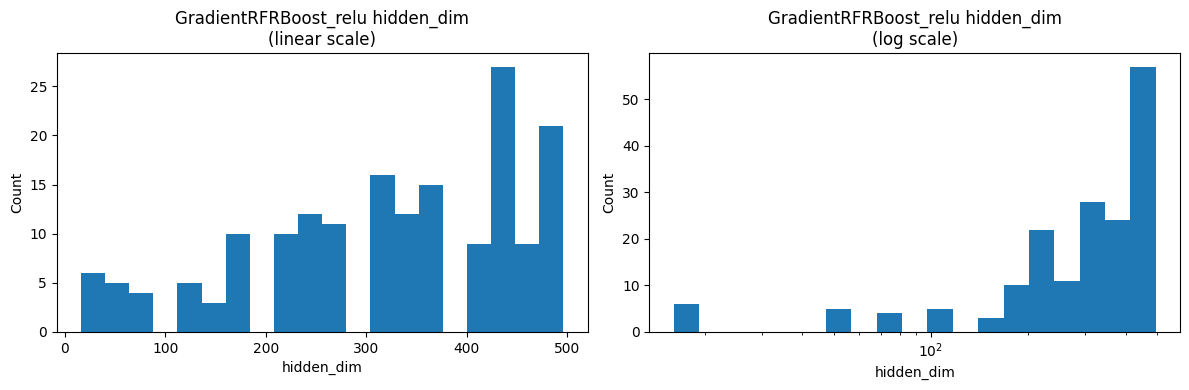

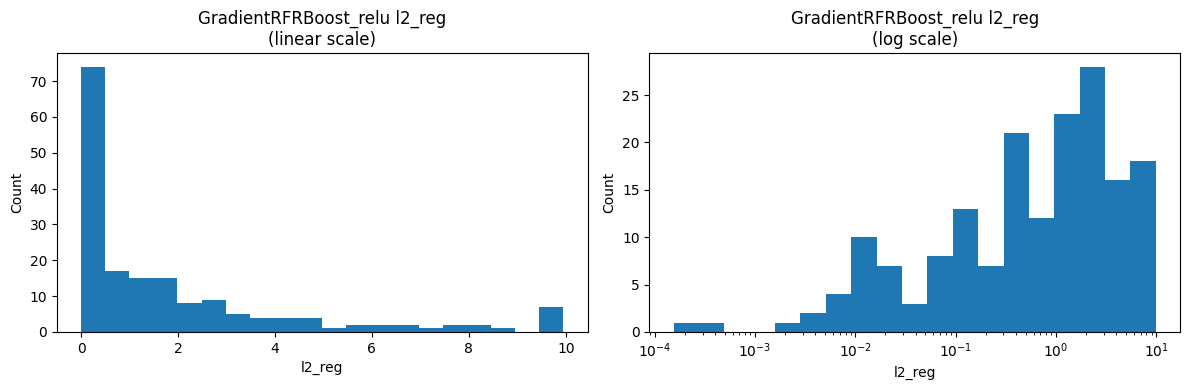

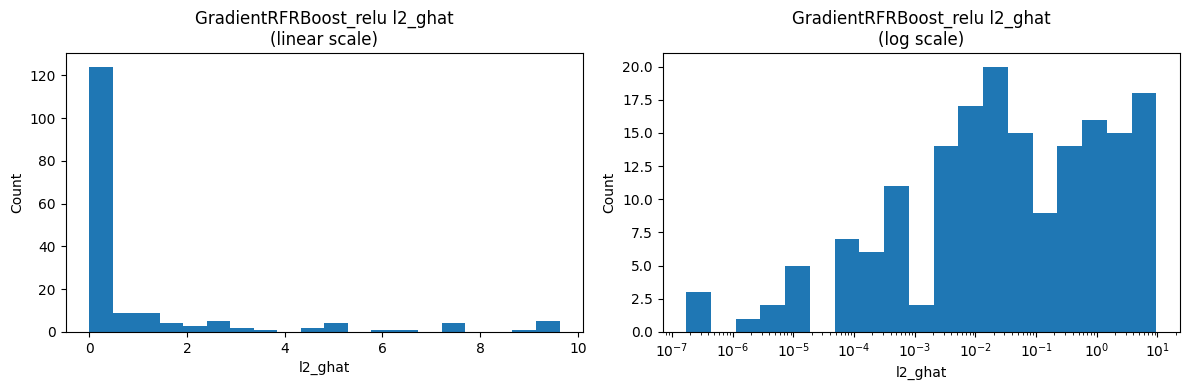

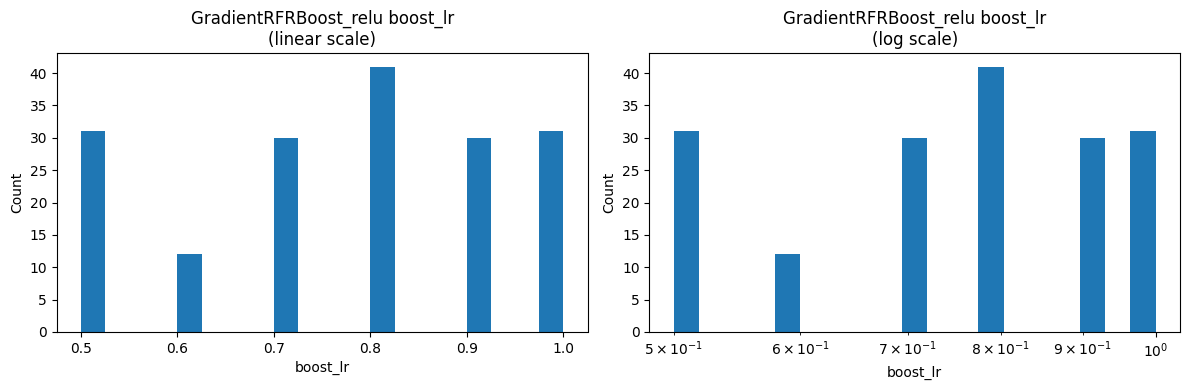

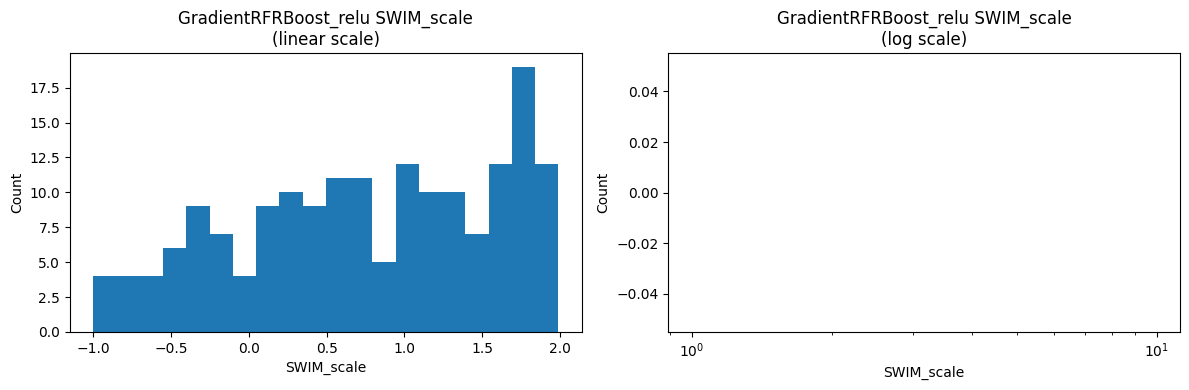

Model: GreedyRFRBoostDense


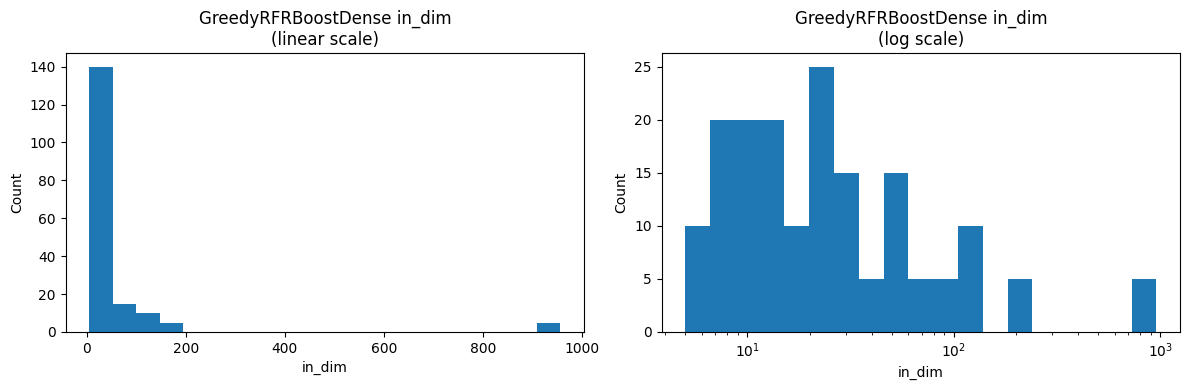

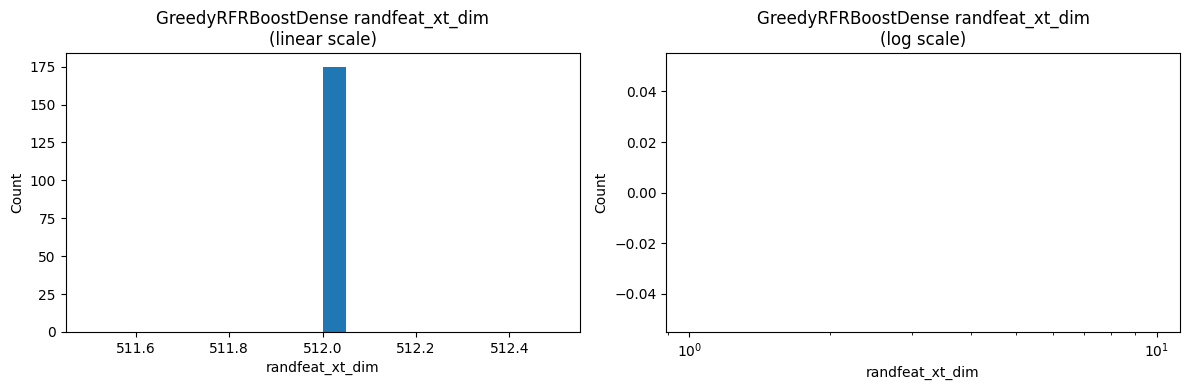

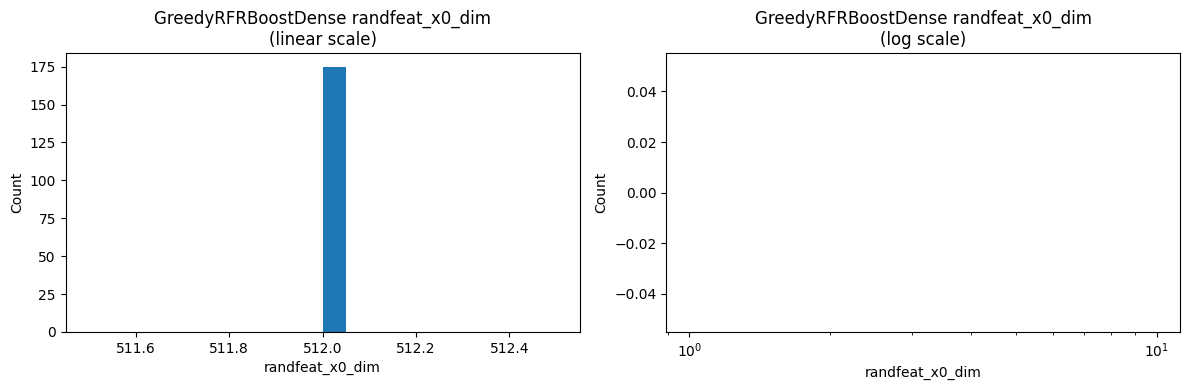

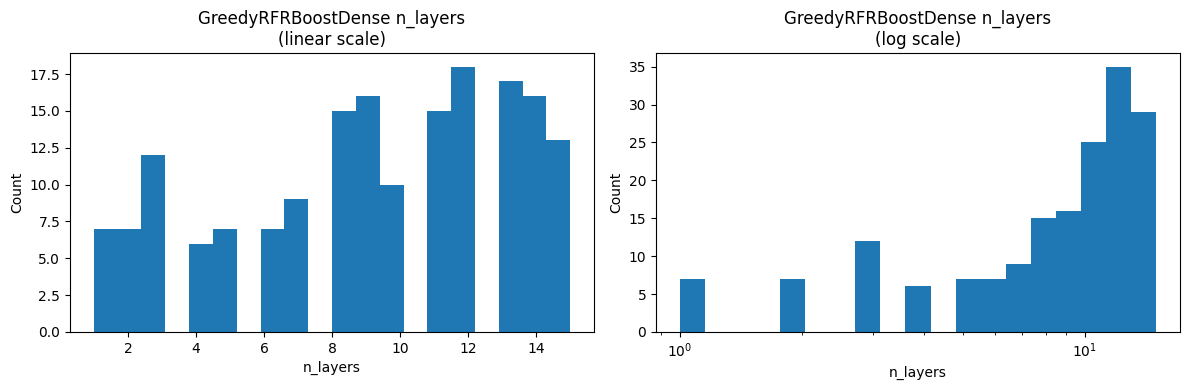

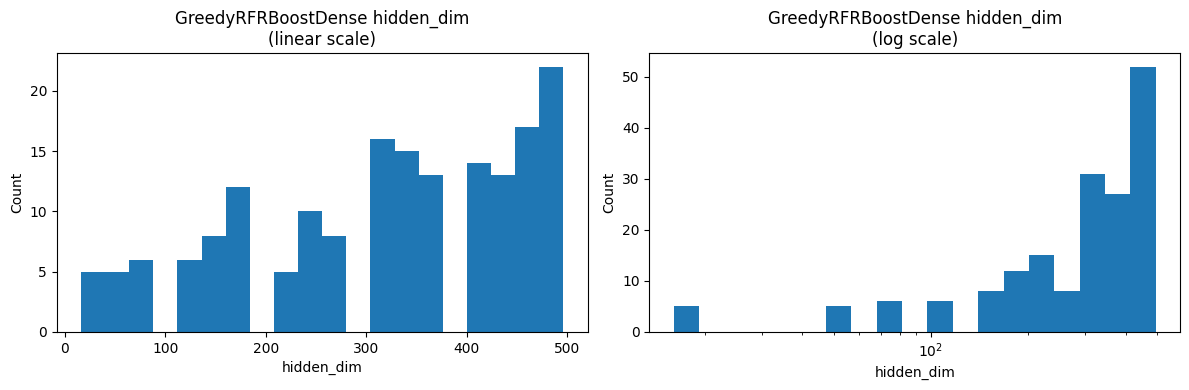

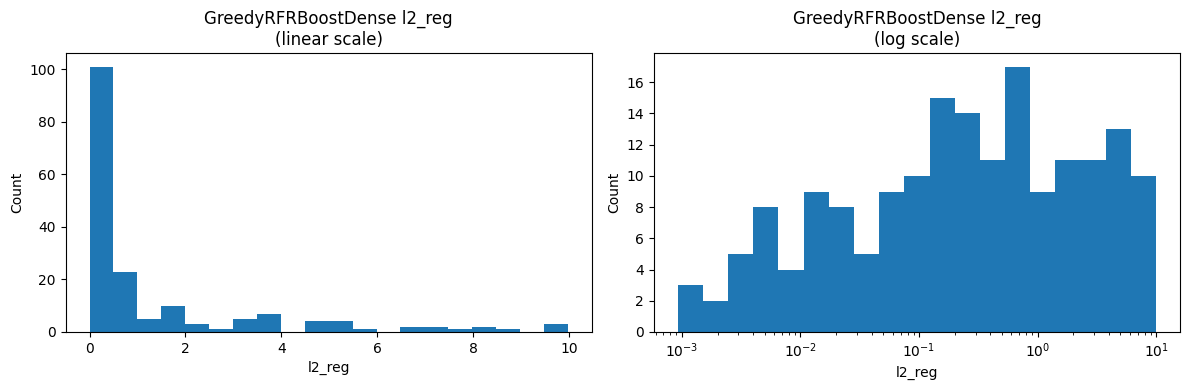

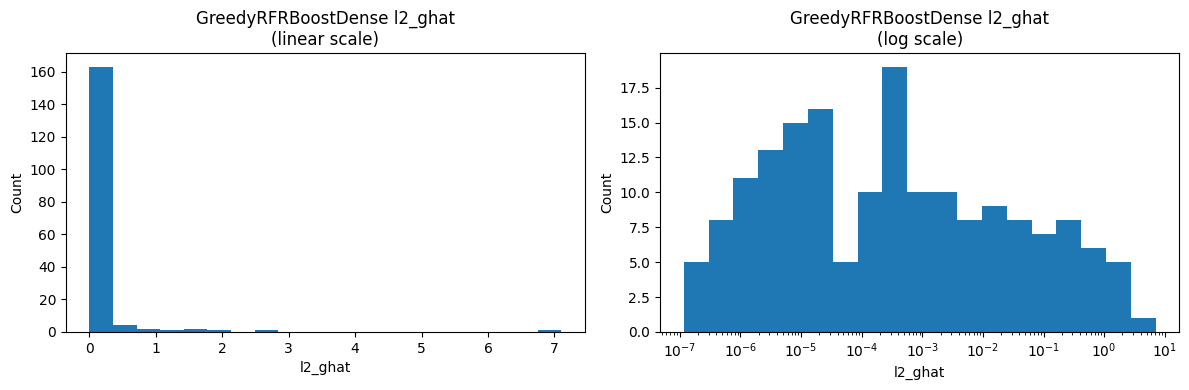

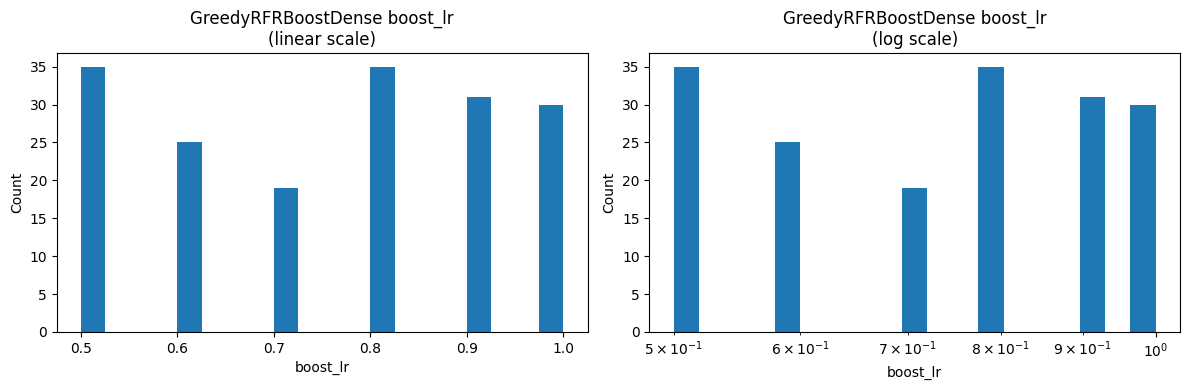

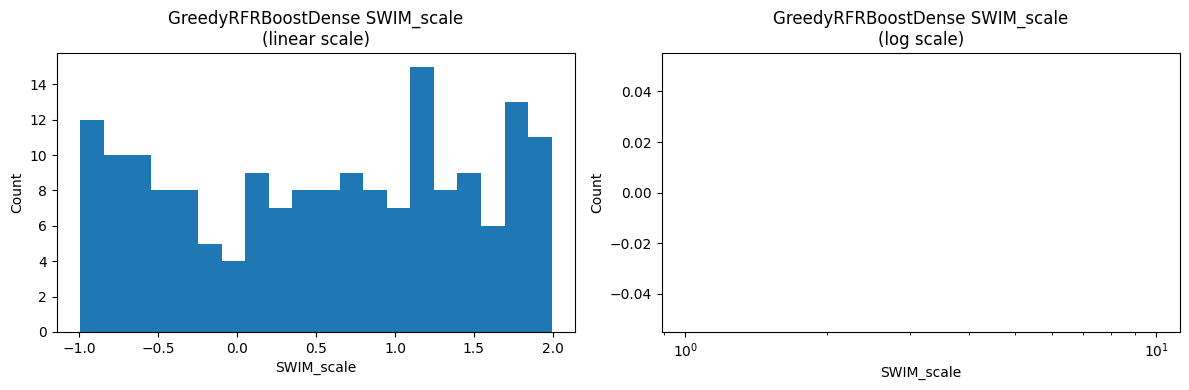

Model: GreedyRFRBoostDiag


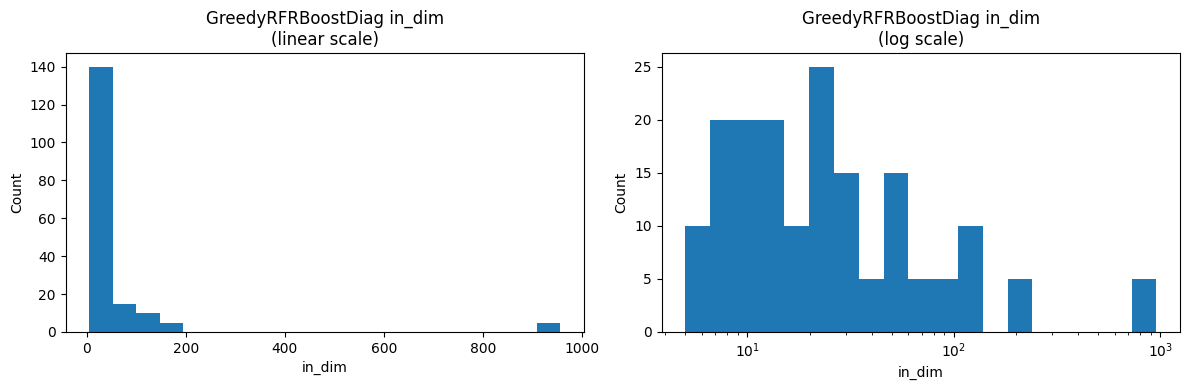

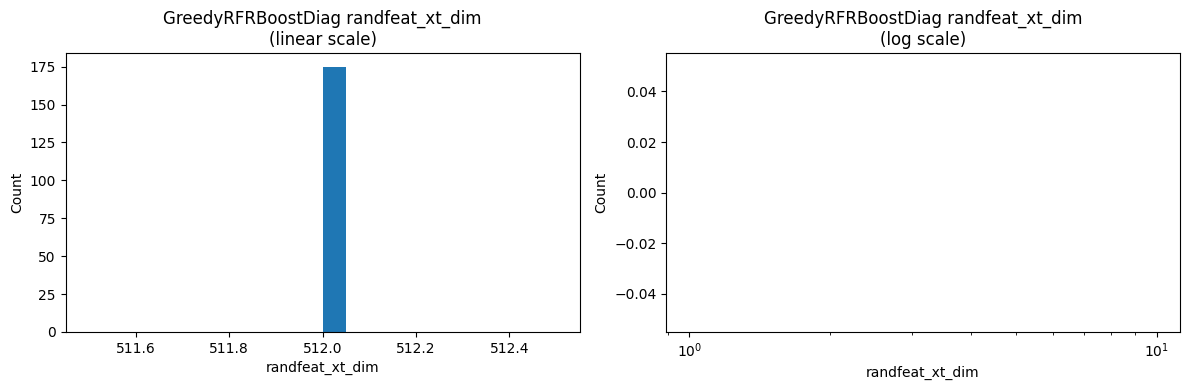

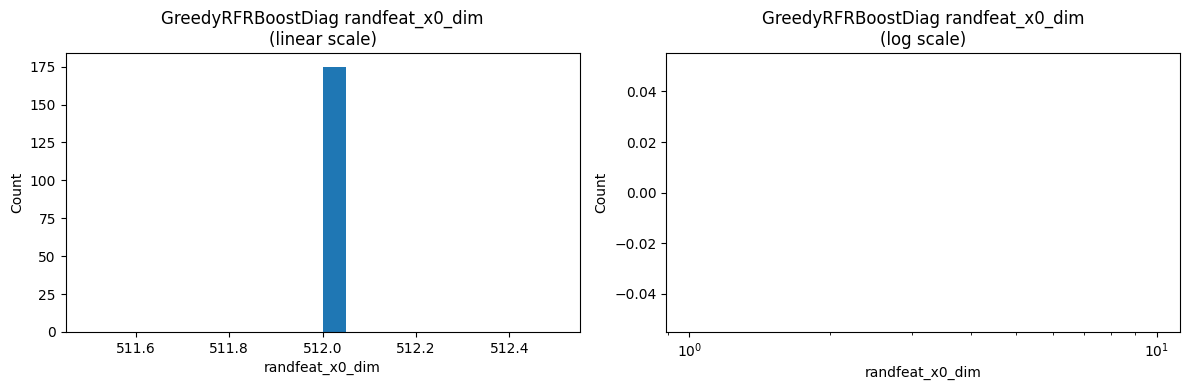

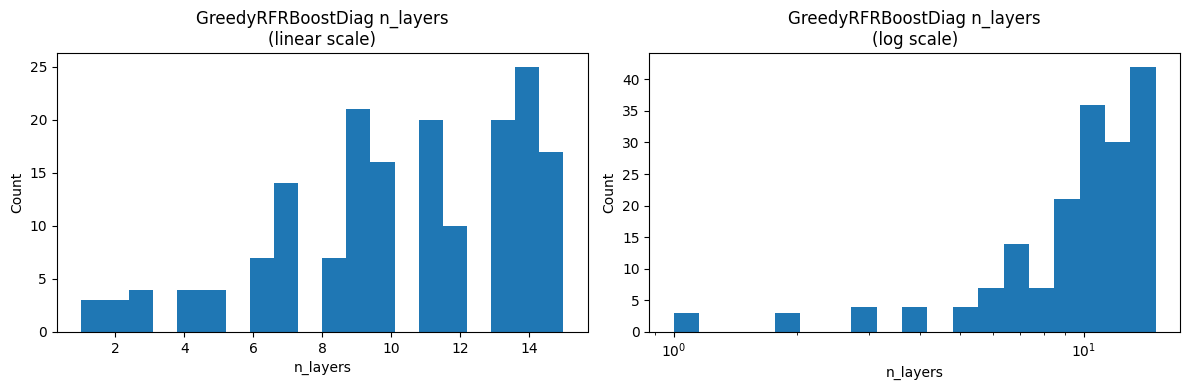

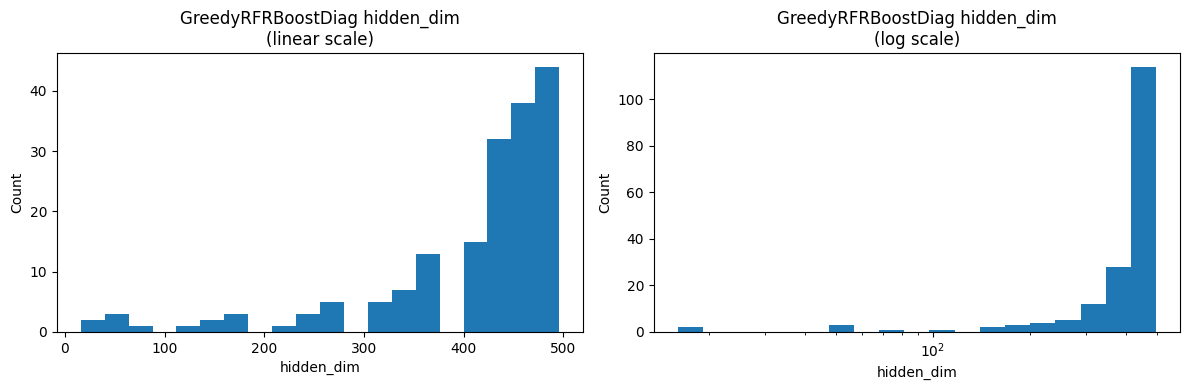

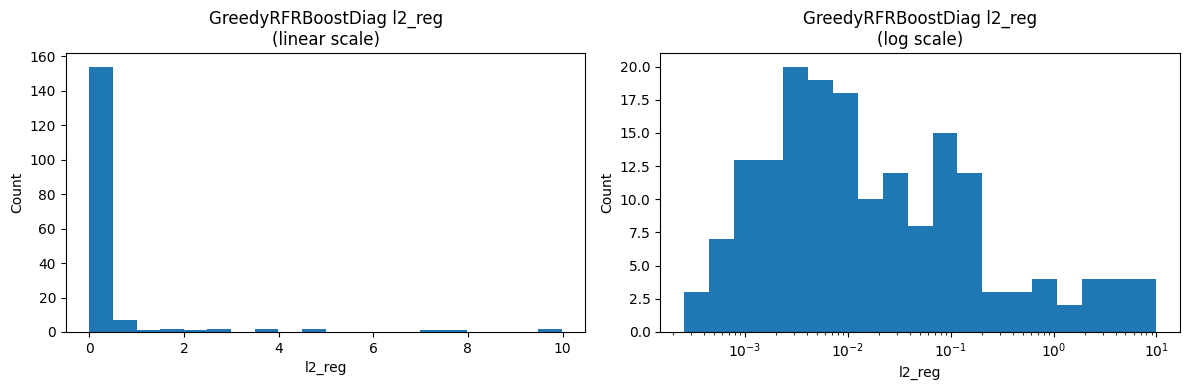

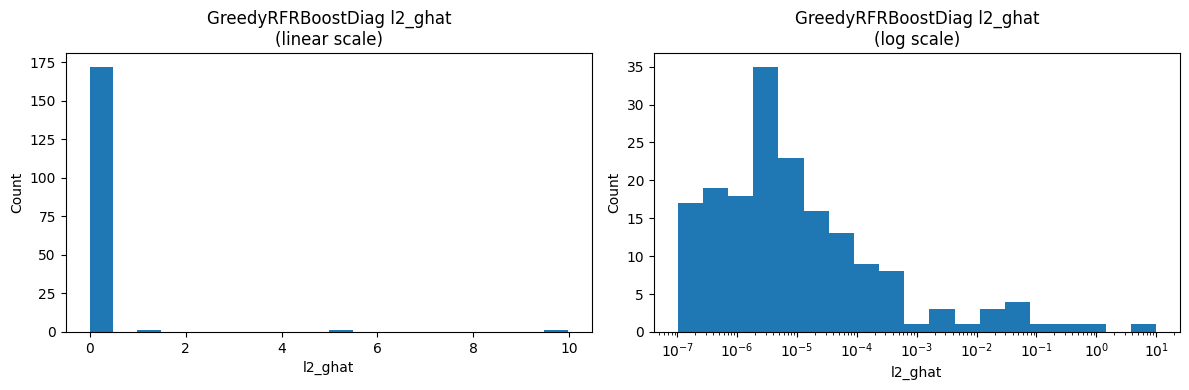

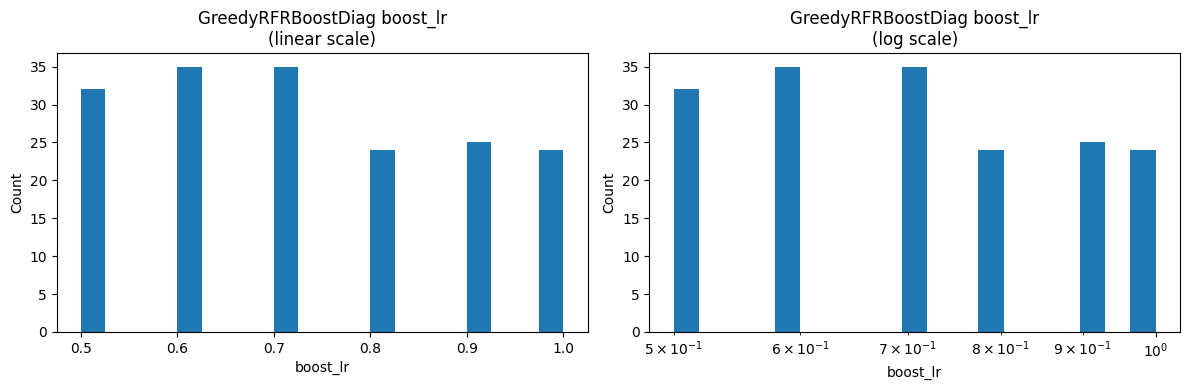

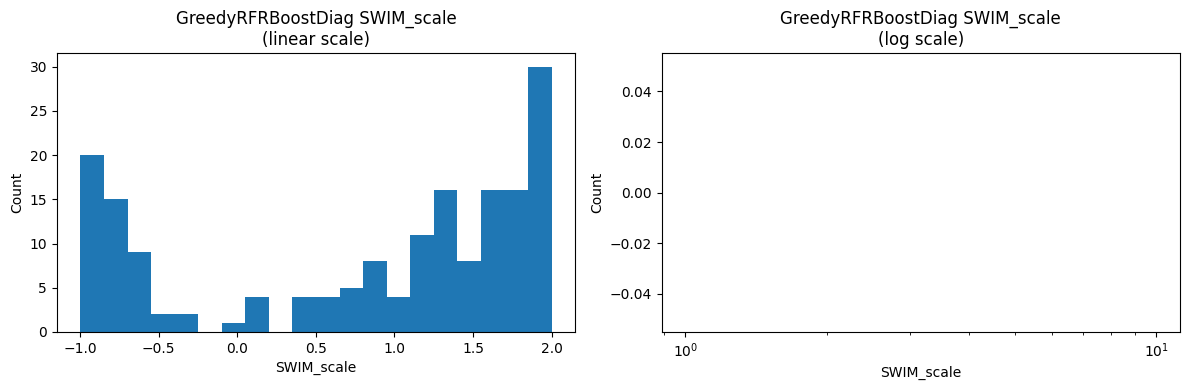

Model: GreedyRFRBoostScalar


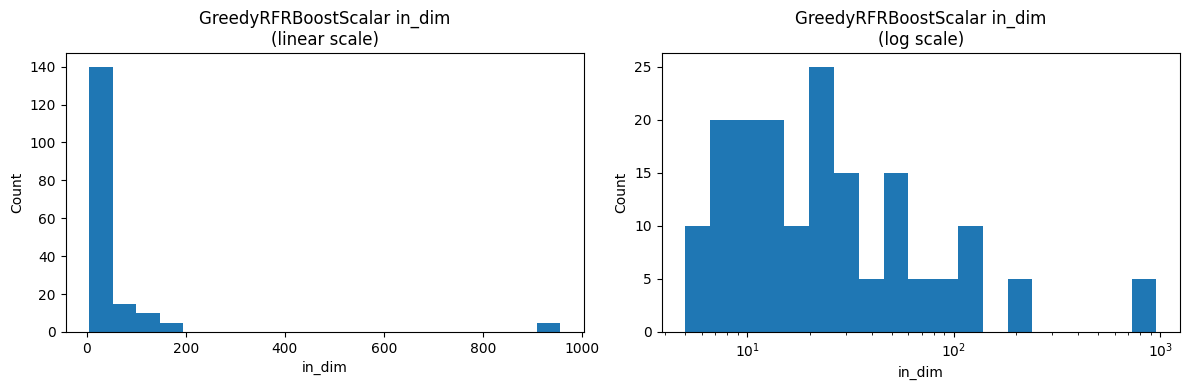

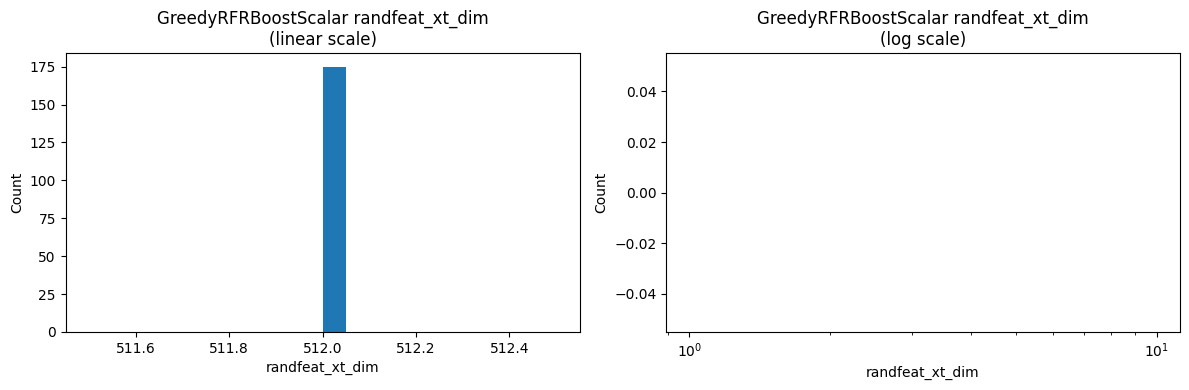

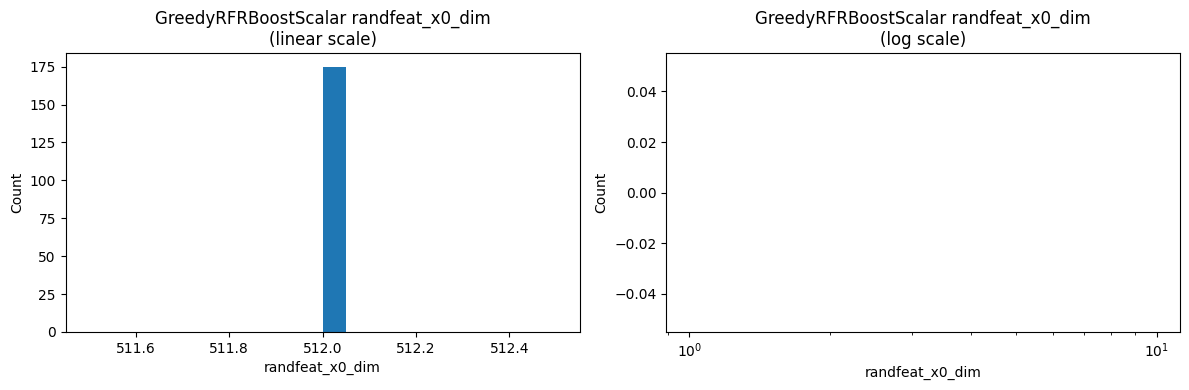

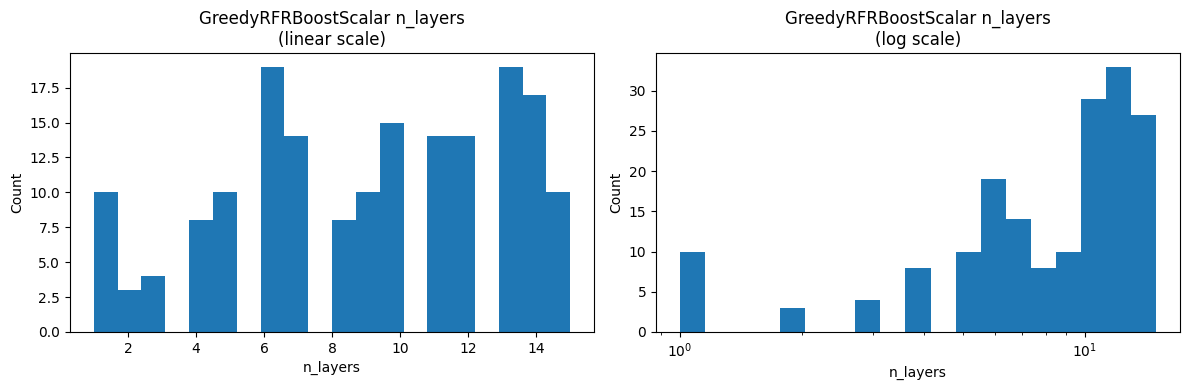

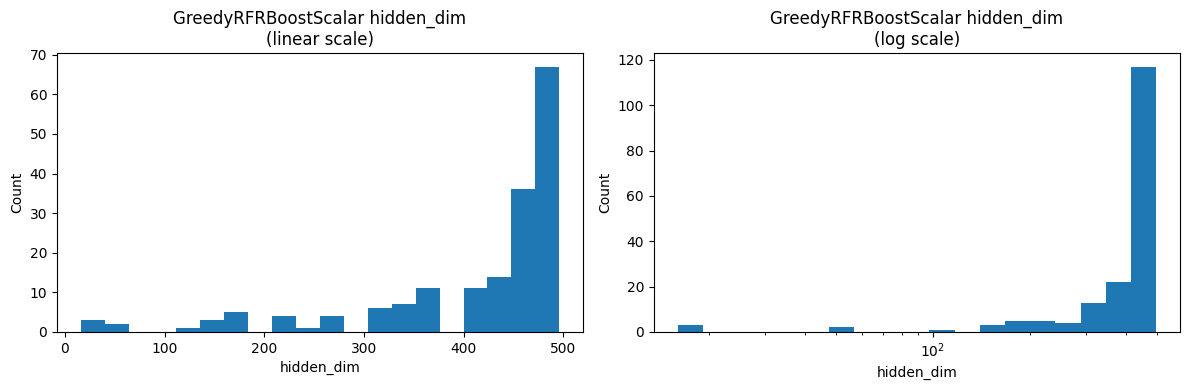

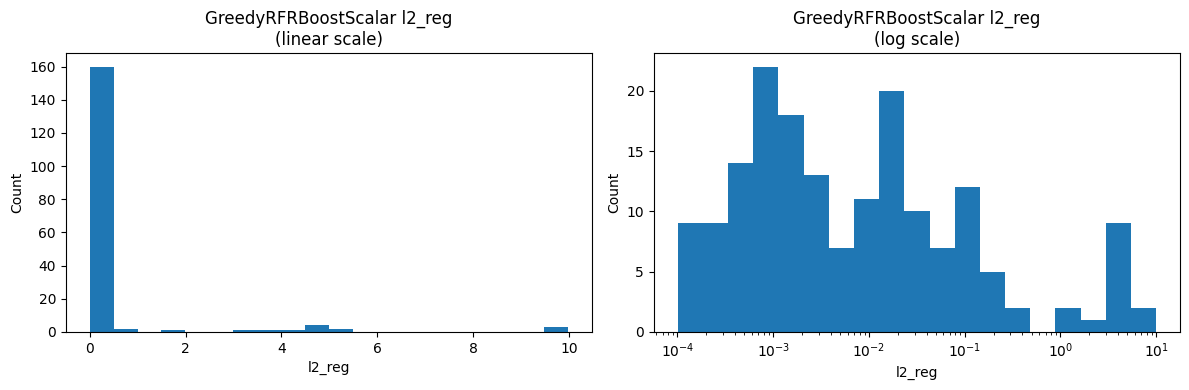

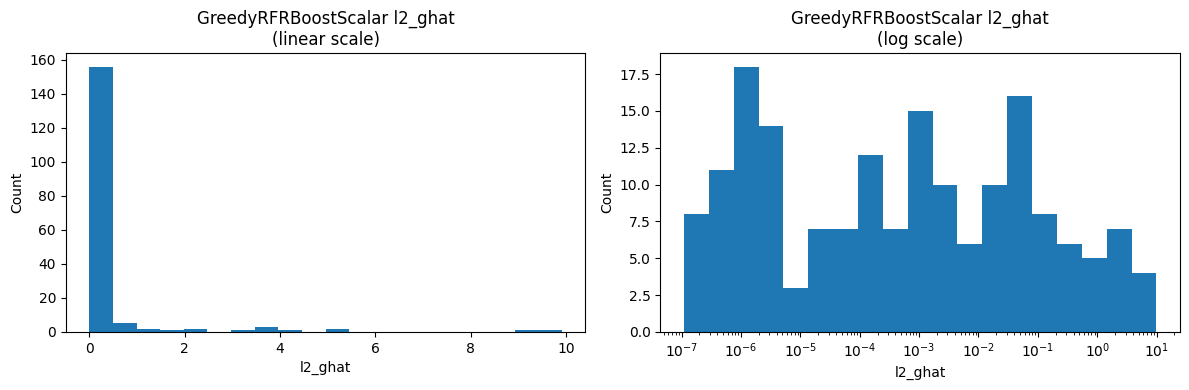

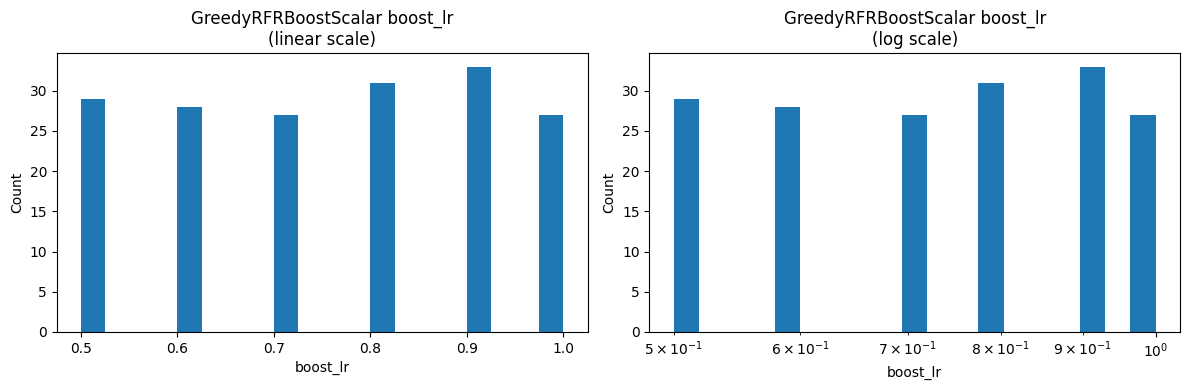

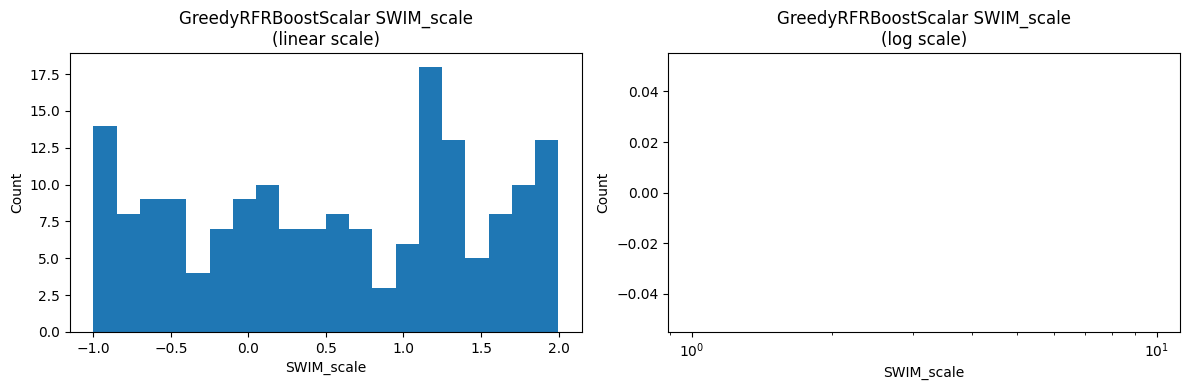

Model: GreedyRFRBoostDense_relu


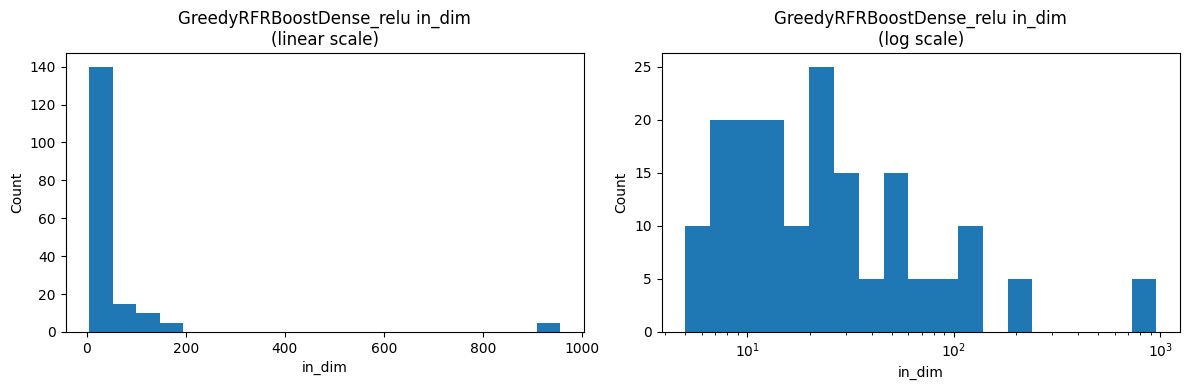

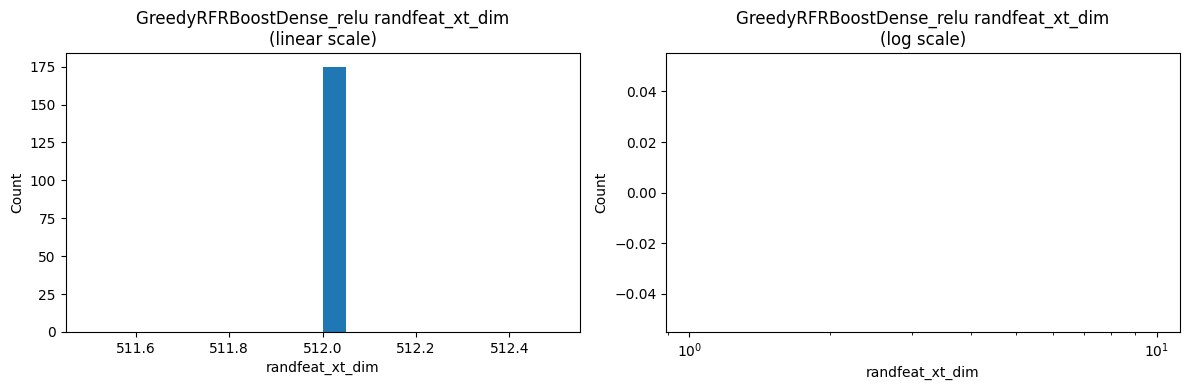

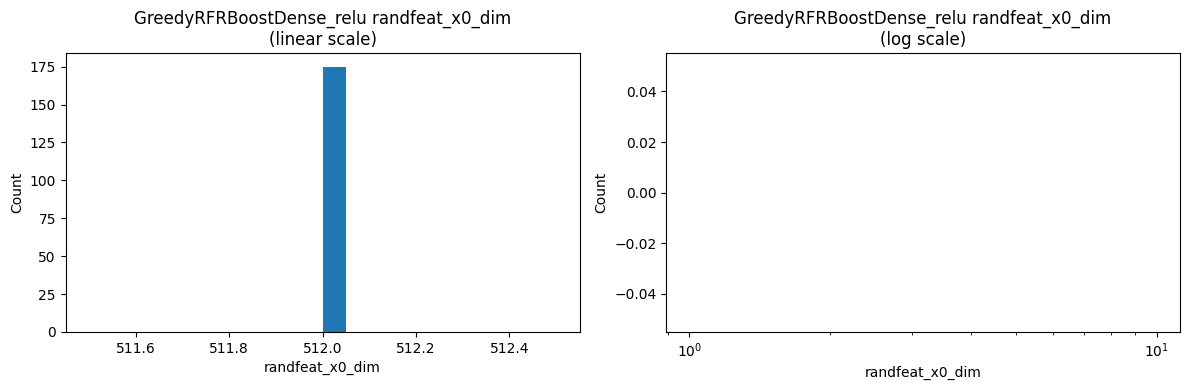

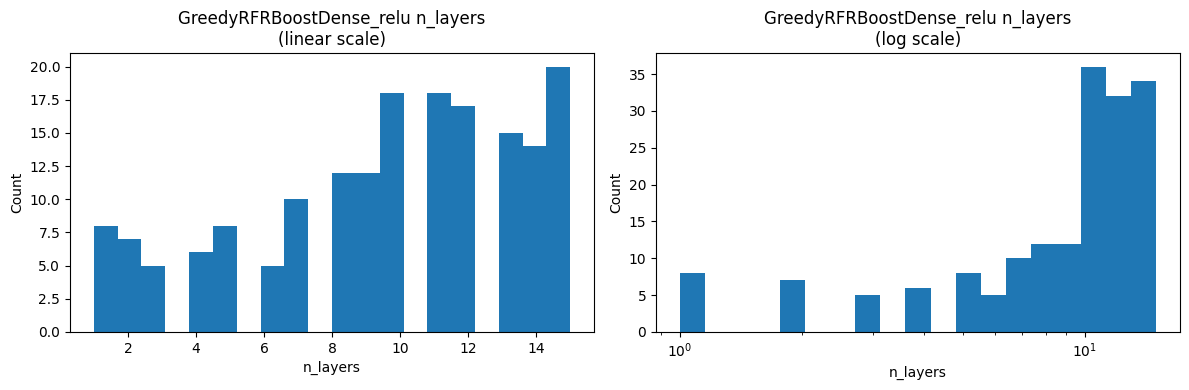

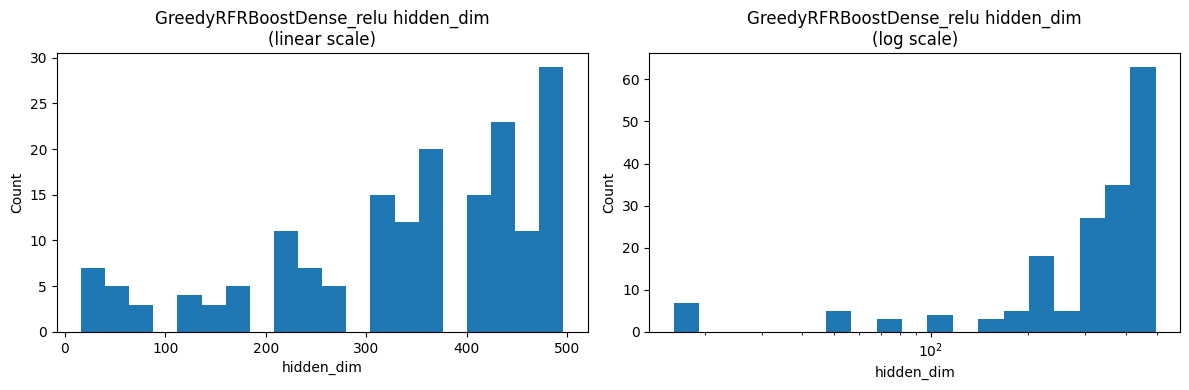

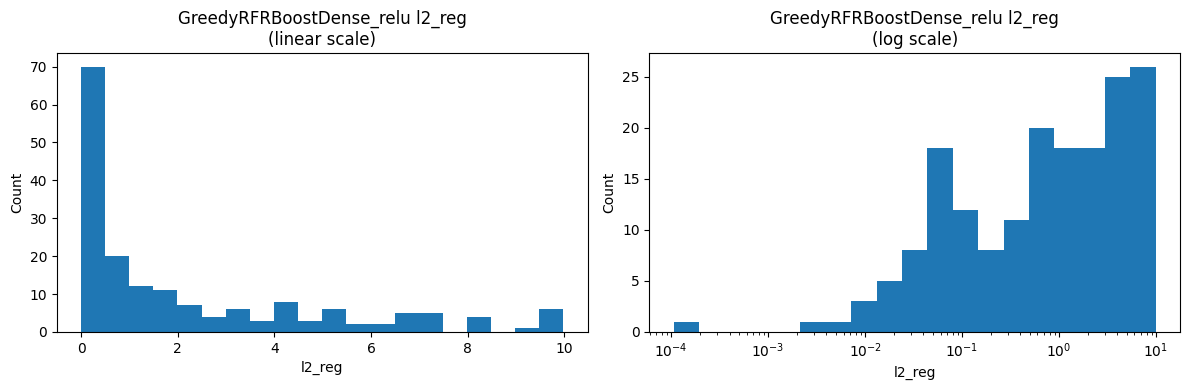

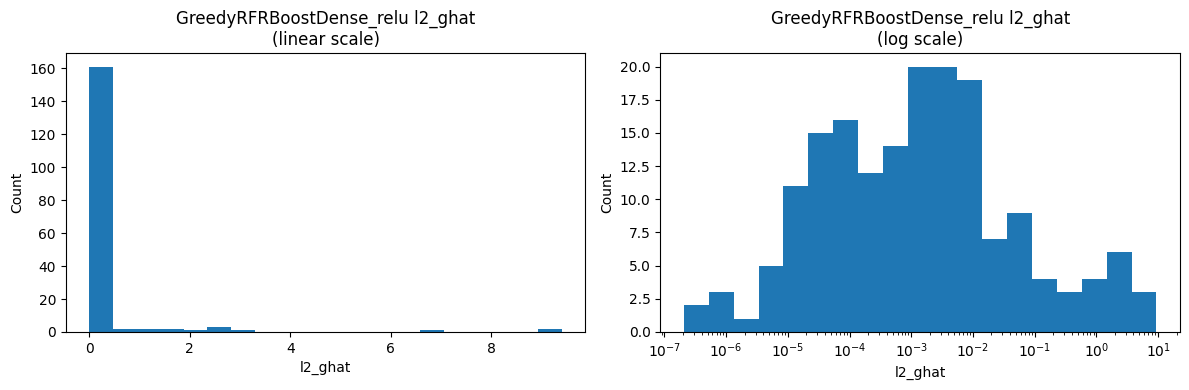

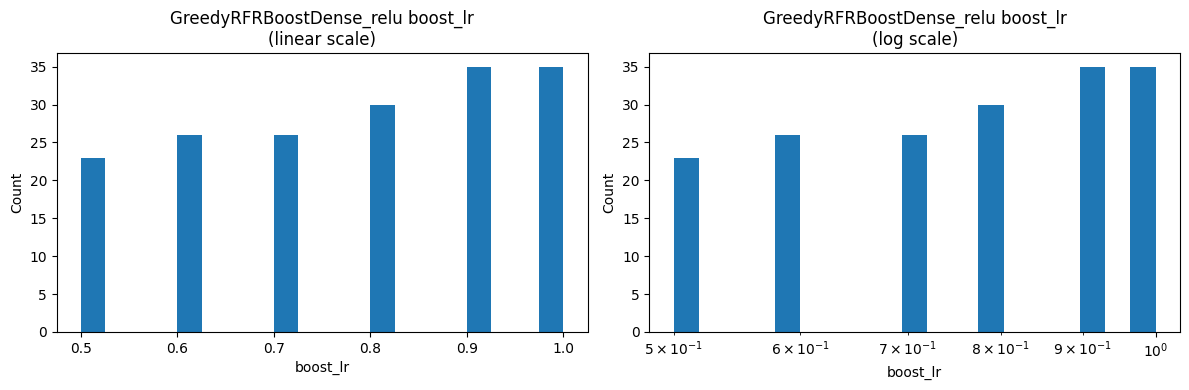

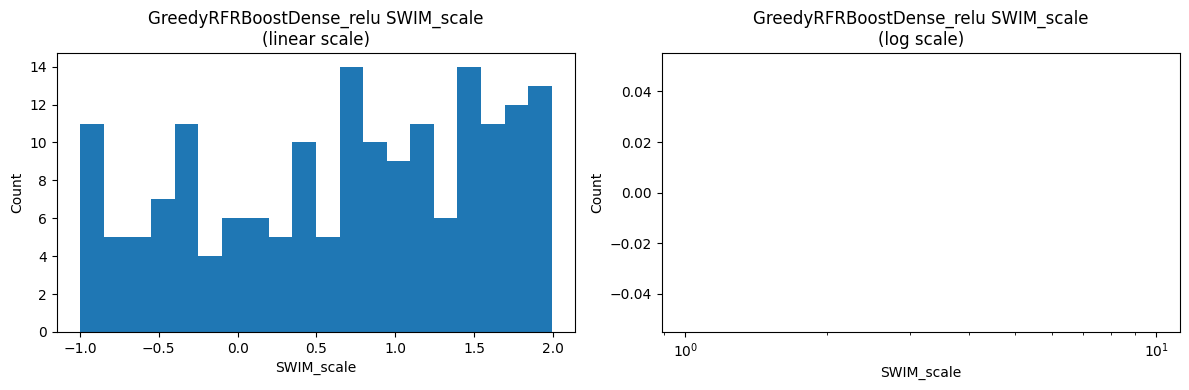

Model: GreedyRFRBoostDiag_relu


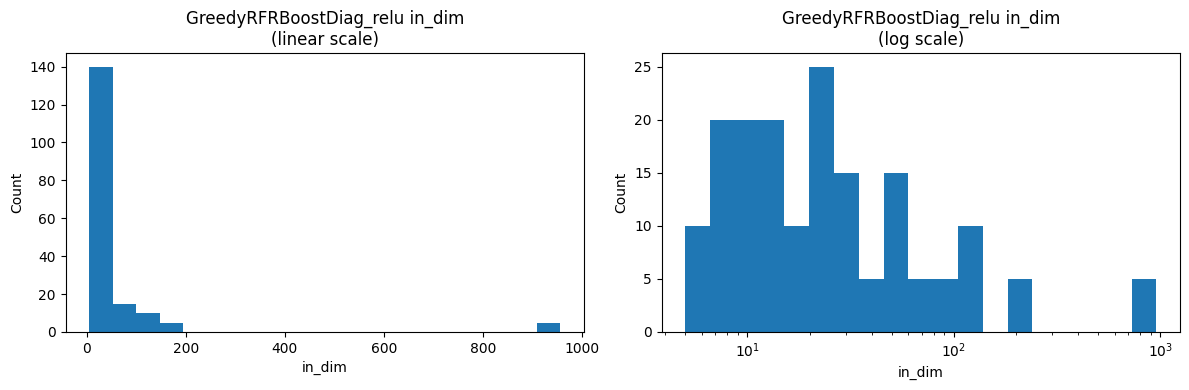

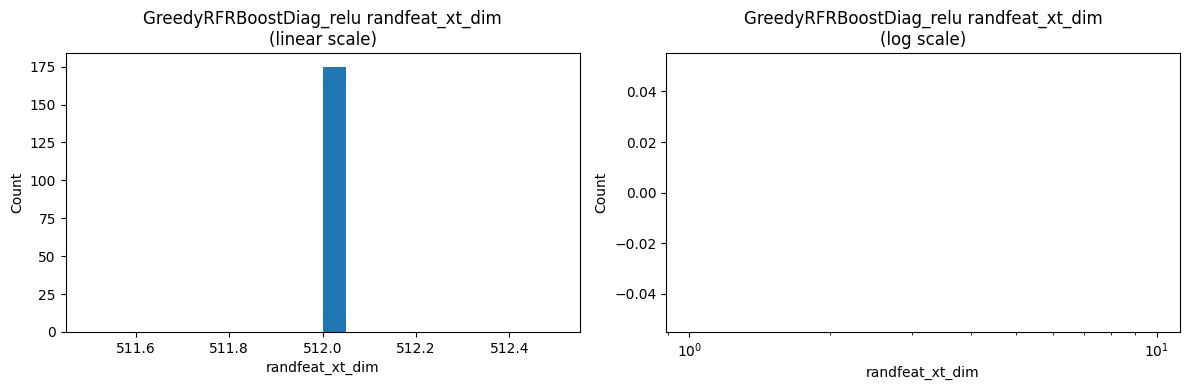

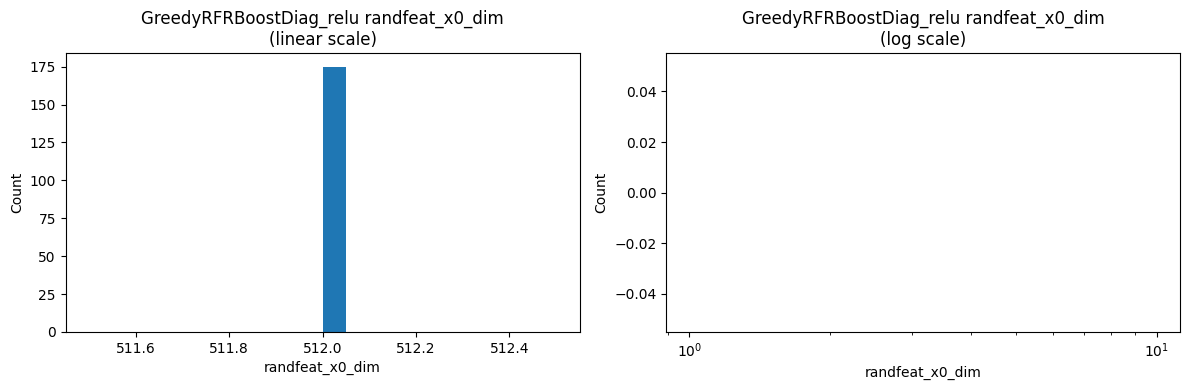

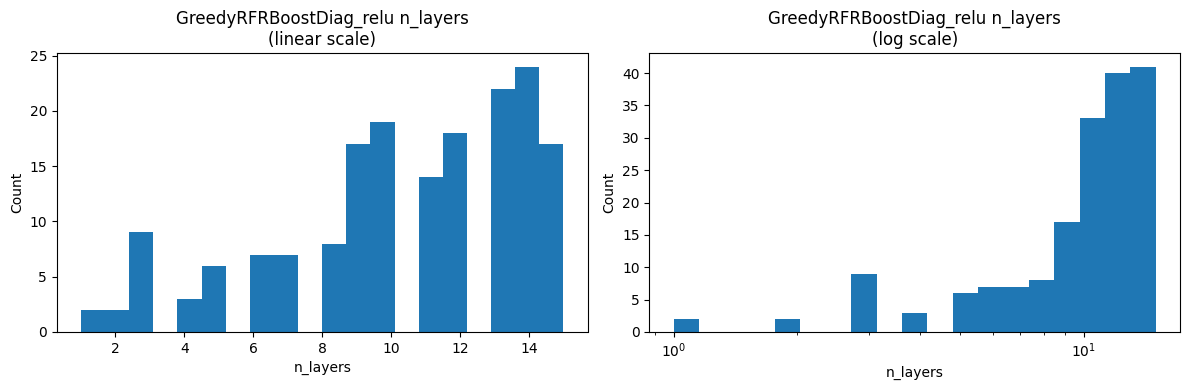

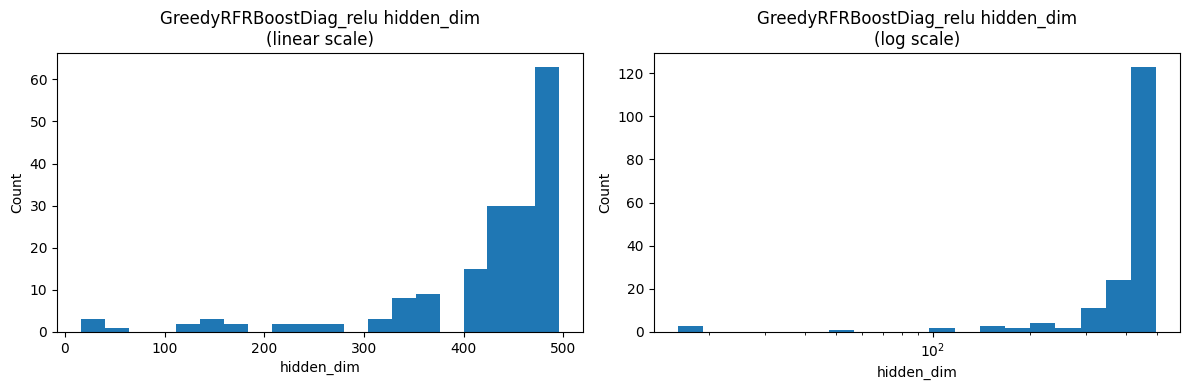

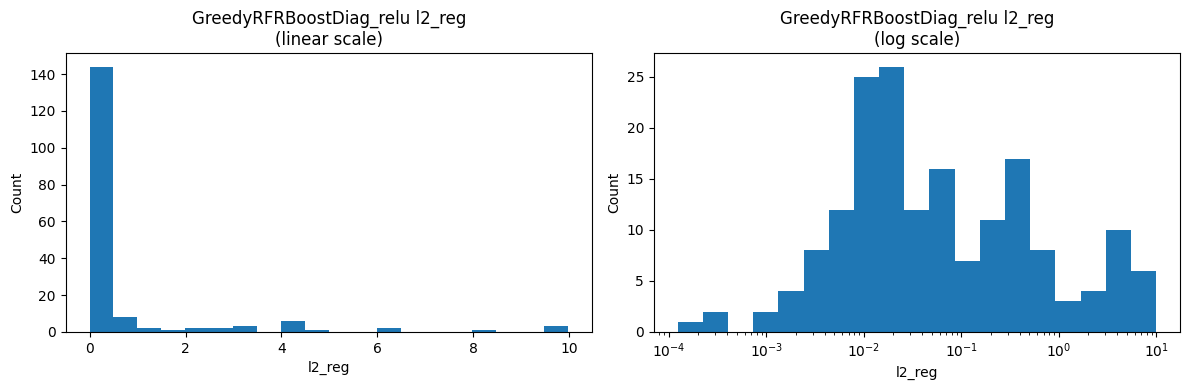

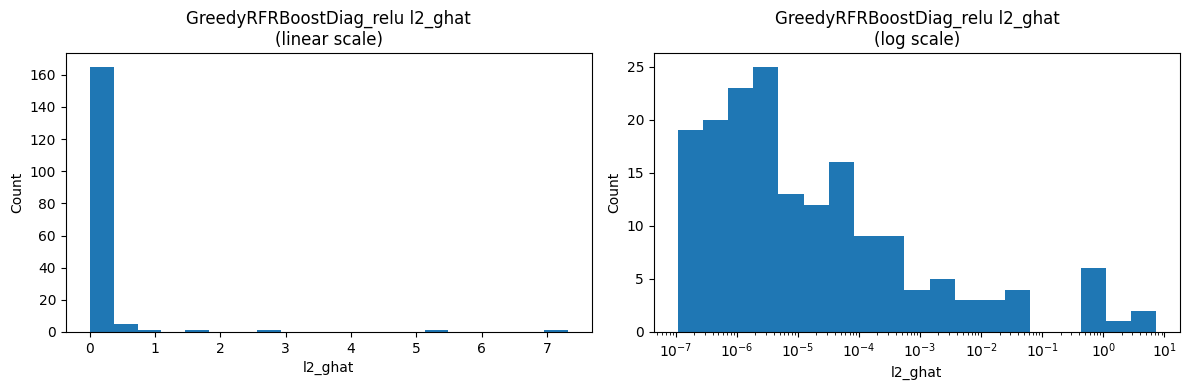

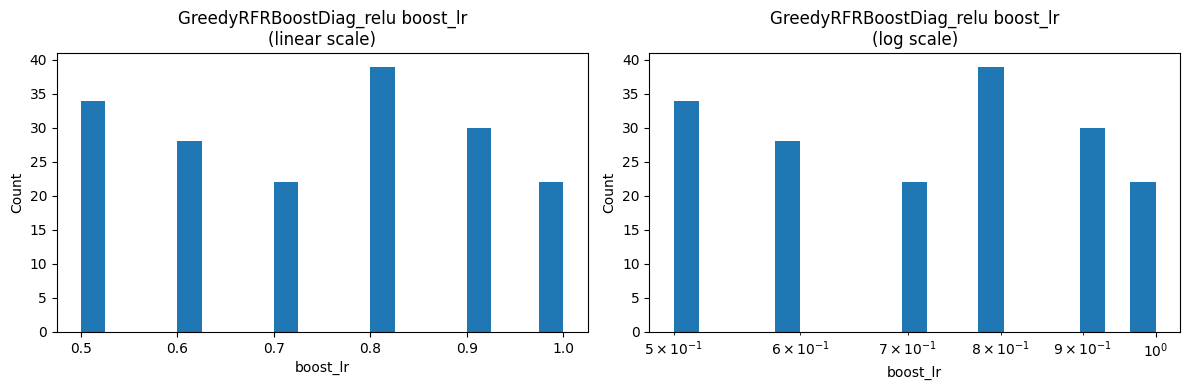

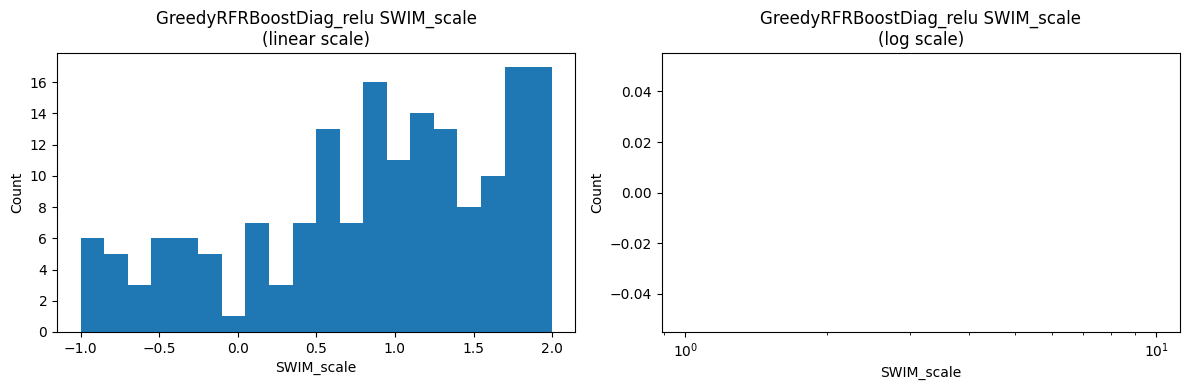

Model: GreedyRFRBoostScalar_relu


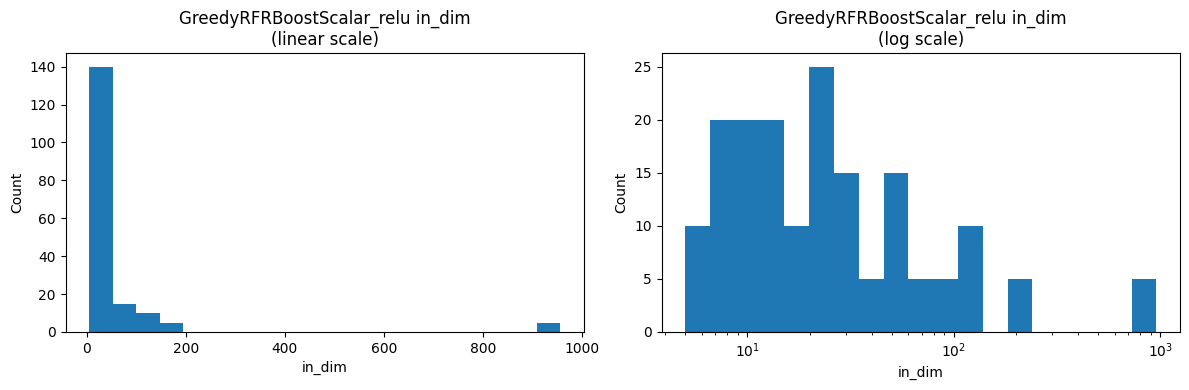

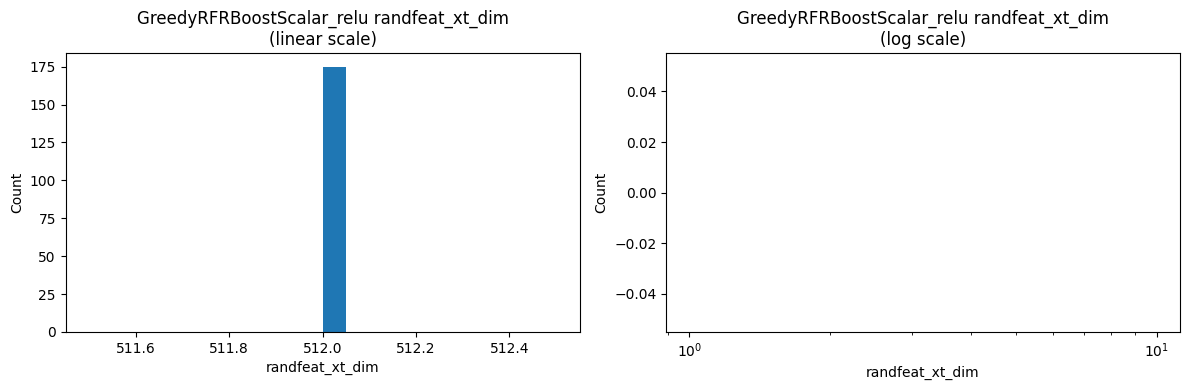

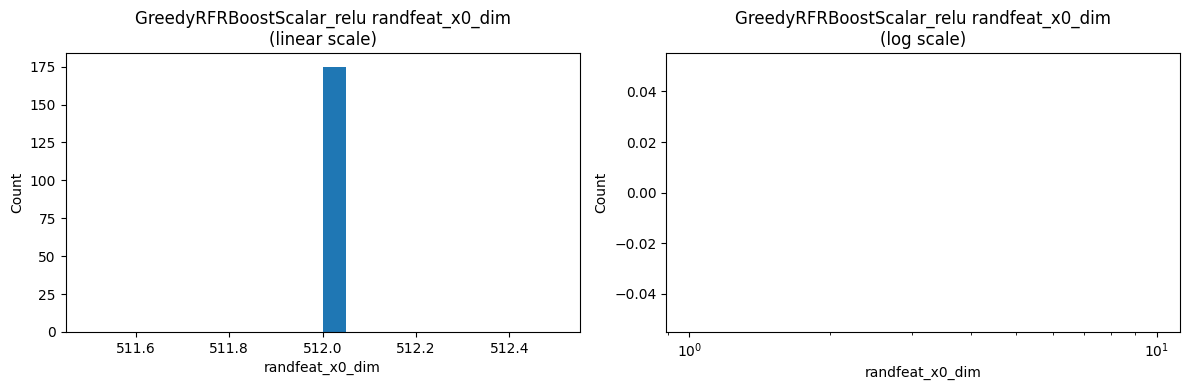

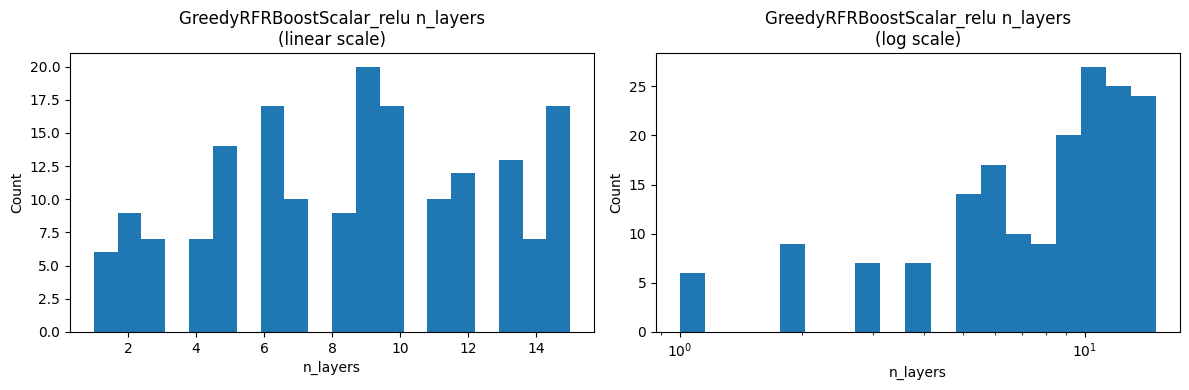

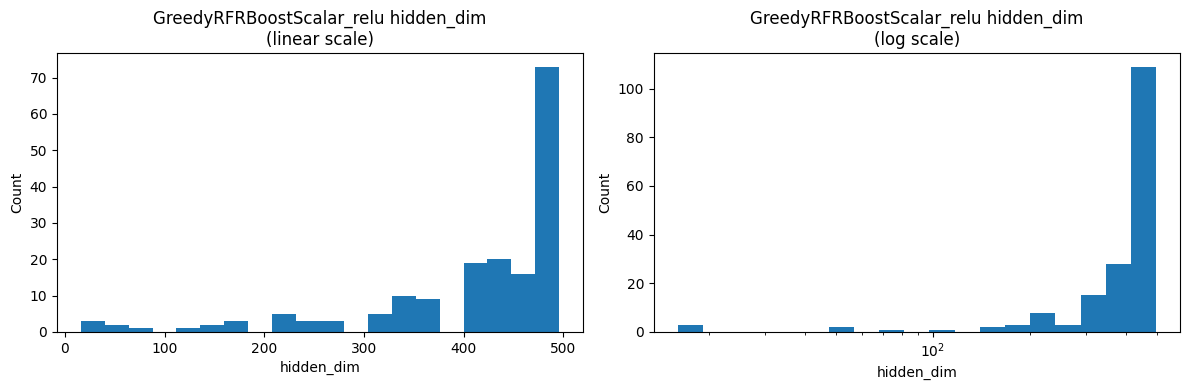

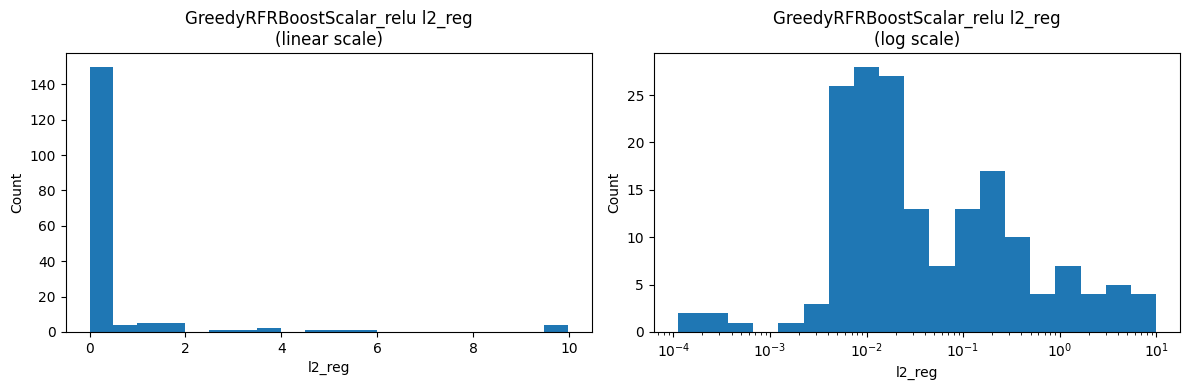

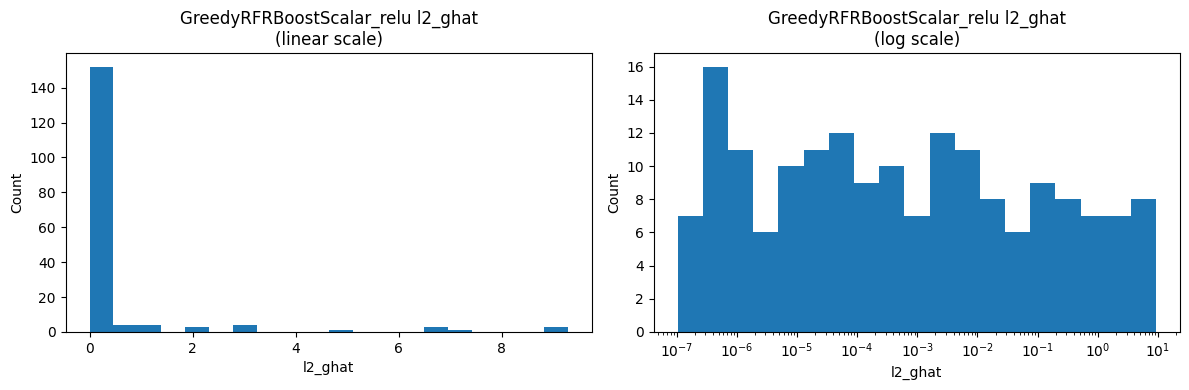

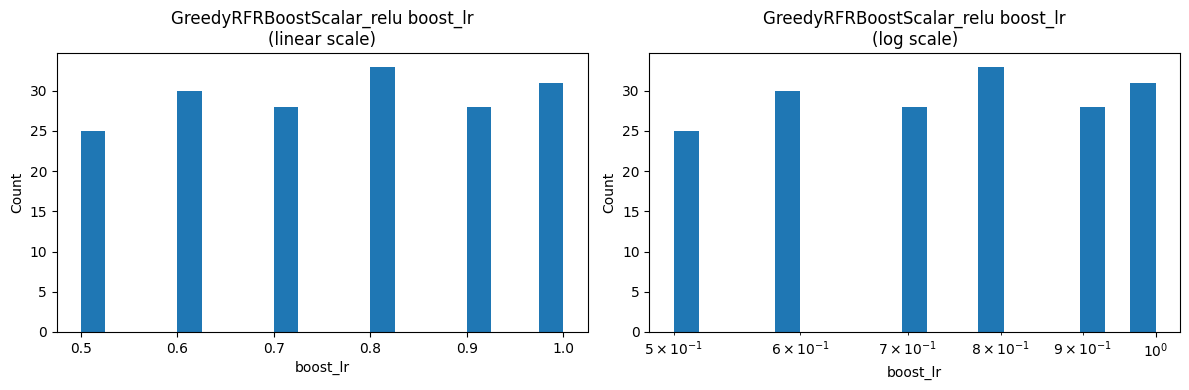

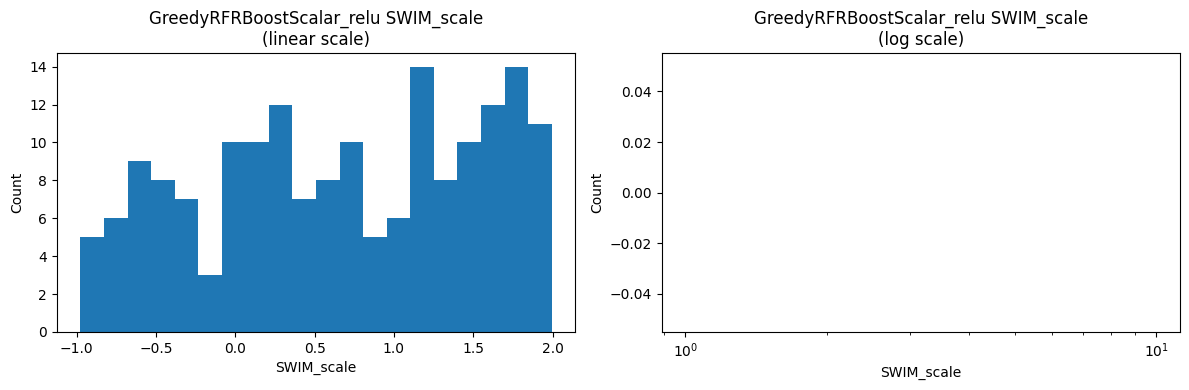

Model: RandomFeatureNetwork


/tmp/ipykernel_22160/3327890562.py:54: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/numpy/core/function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start


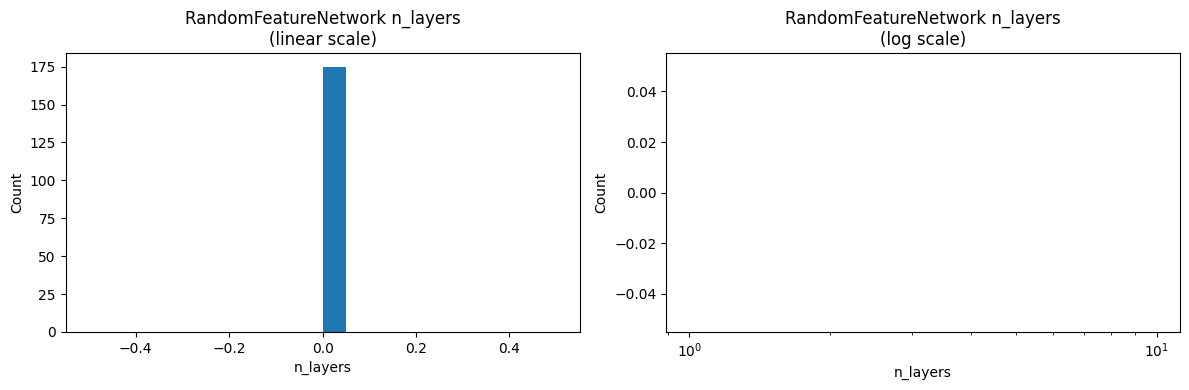

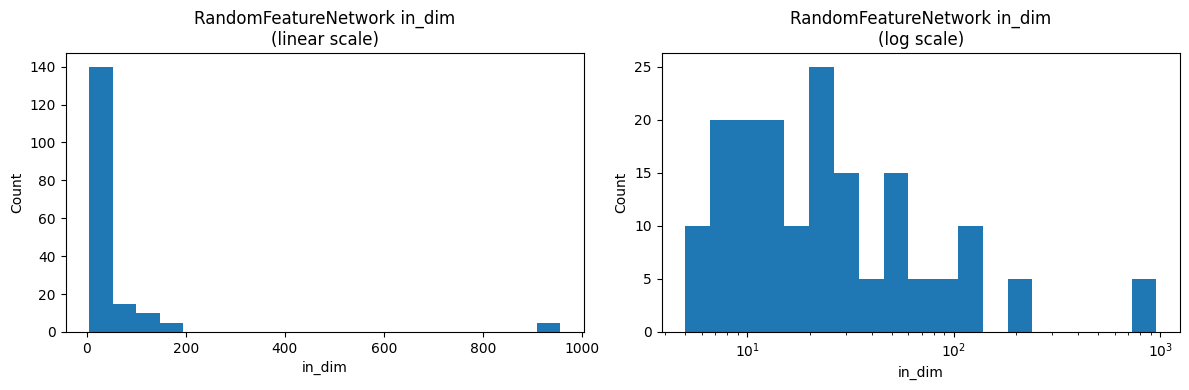

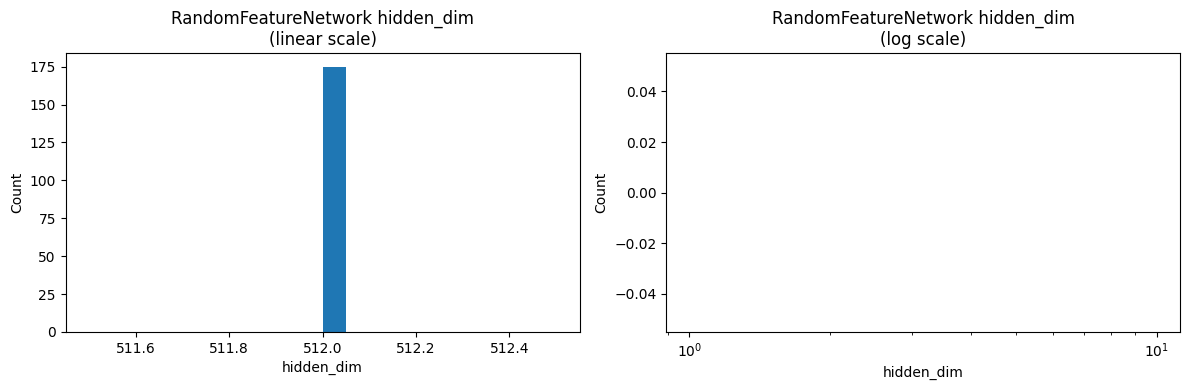

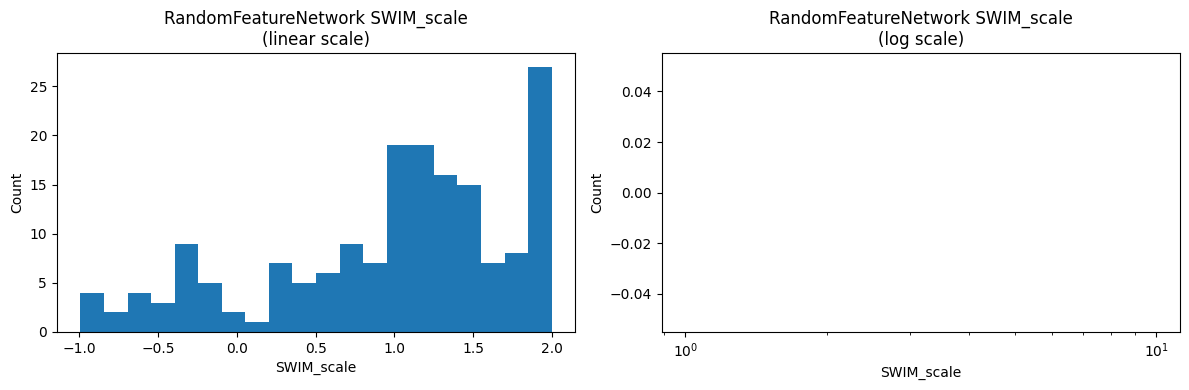

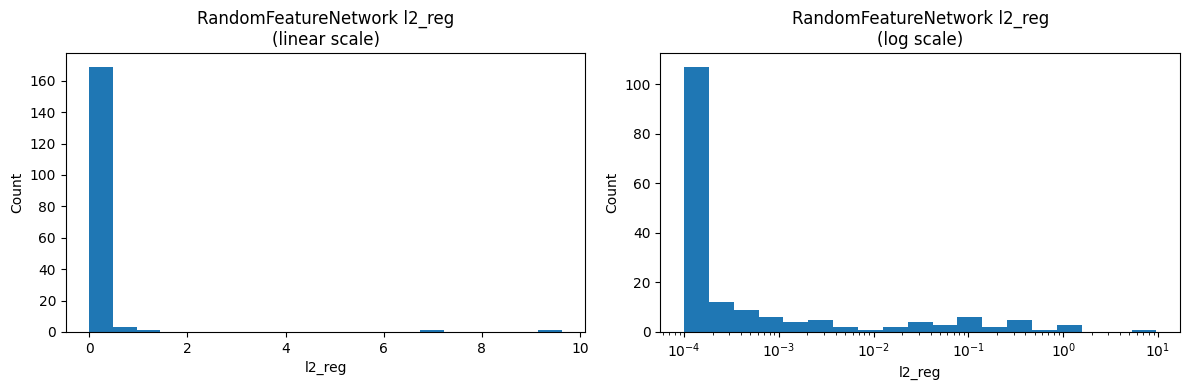

Model: RandomFeatureNetwork_iid


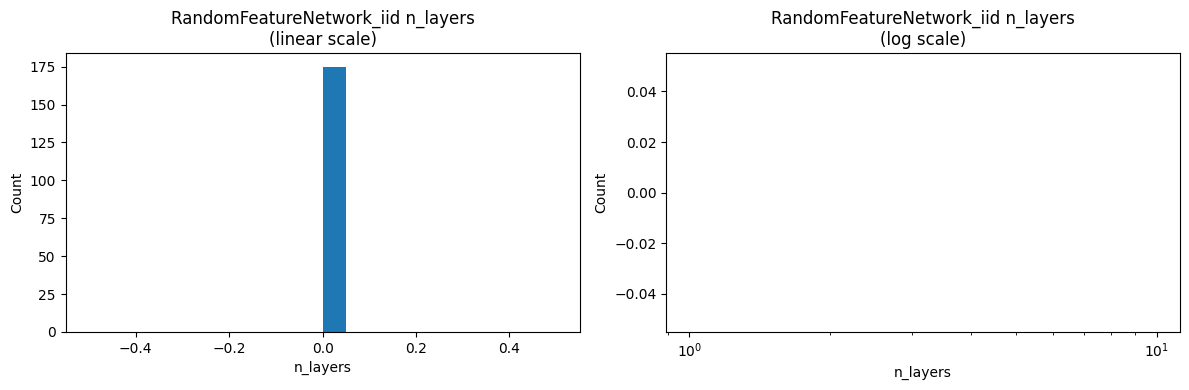

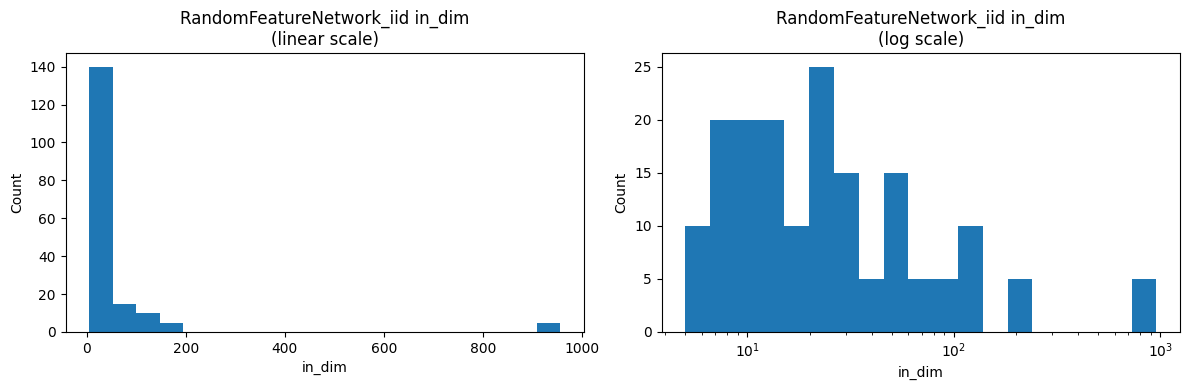

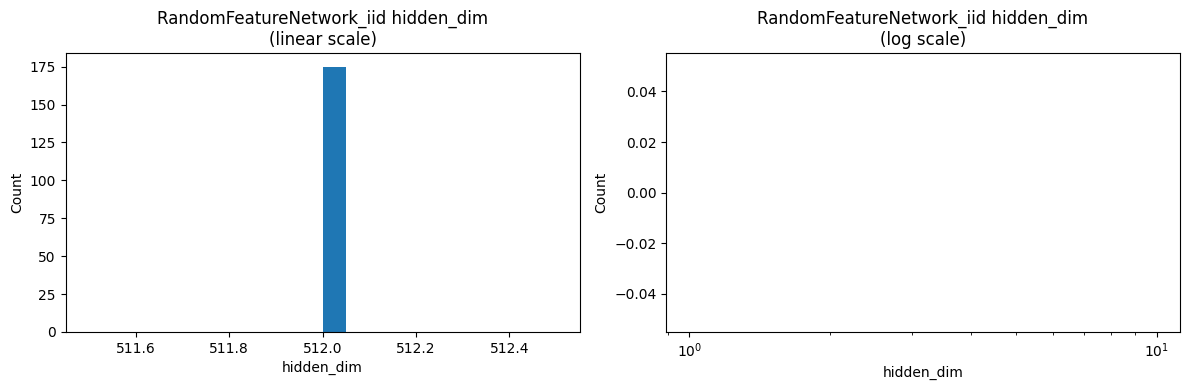

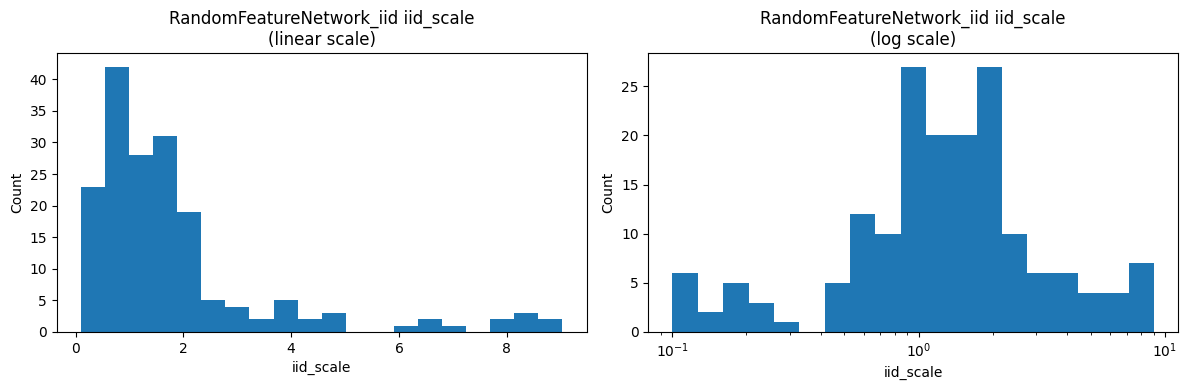

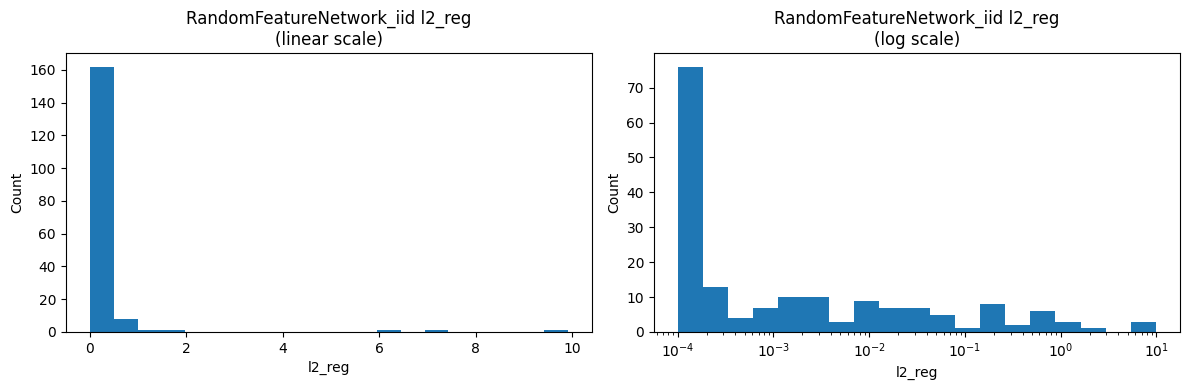

Model: RandomFeatureNetwork_relu


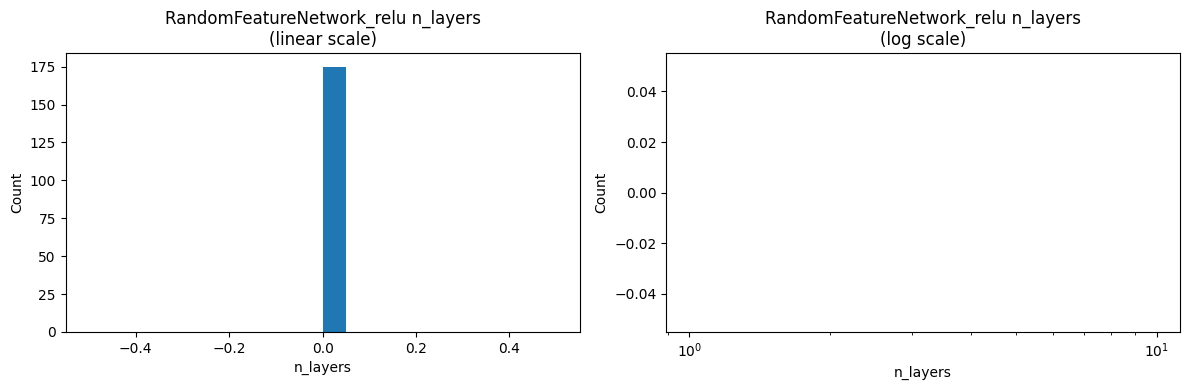

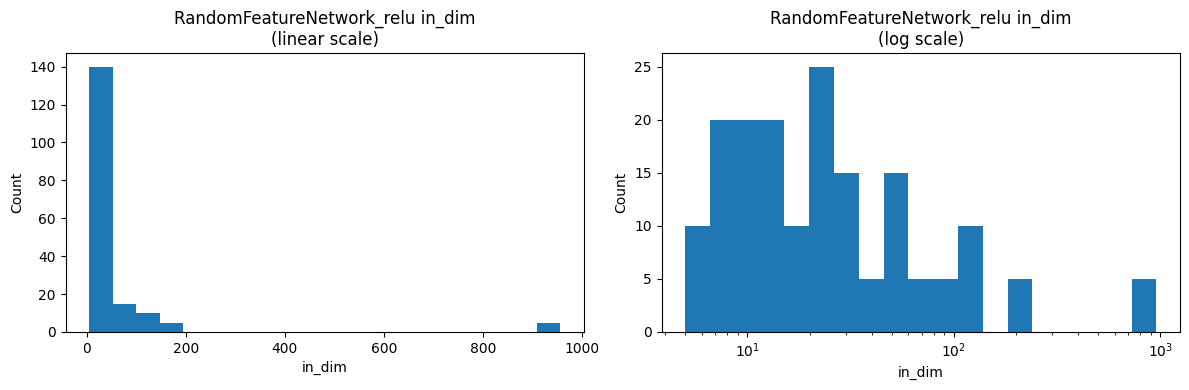

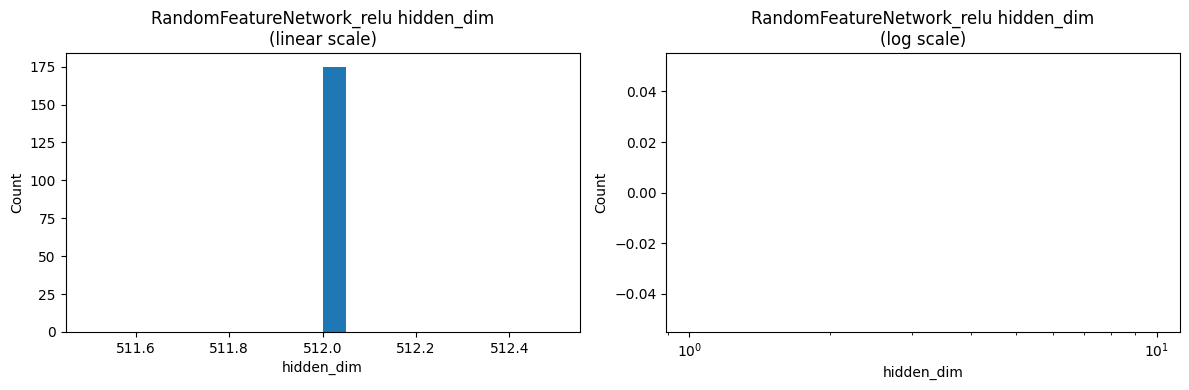

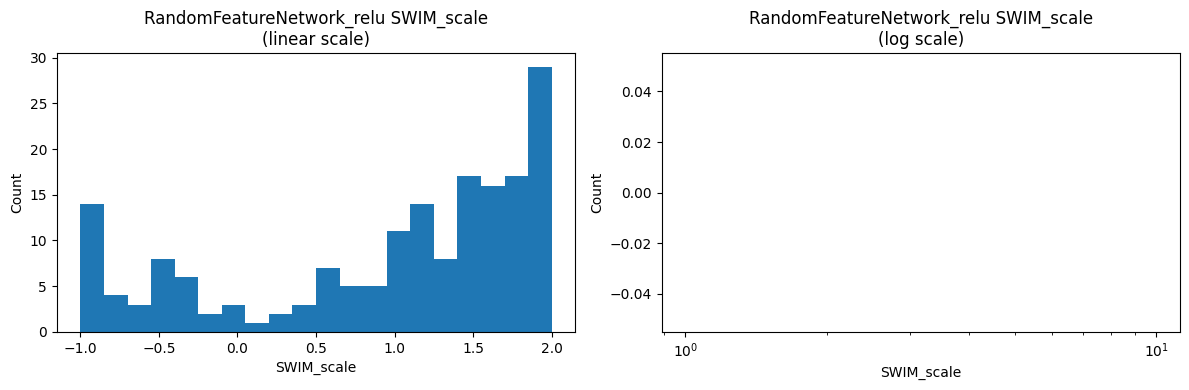

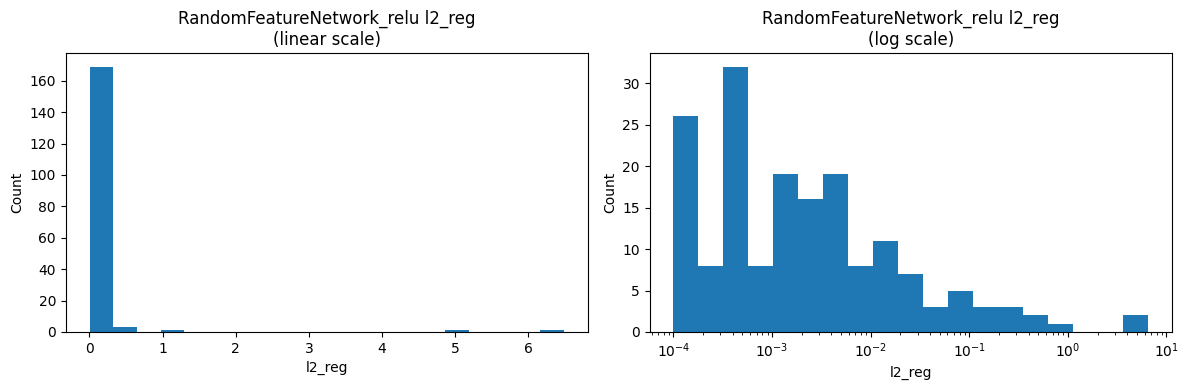

Model: RandomFeatureNetwork_iid_relu


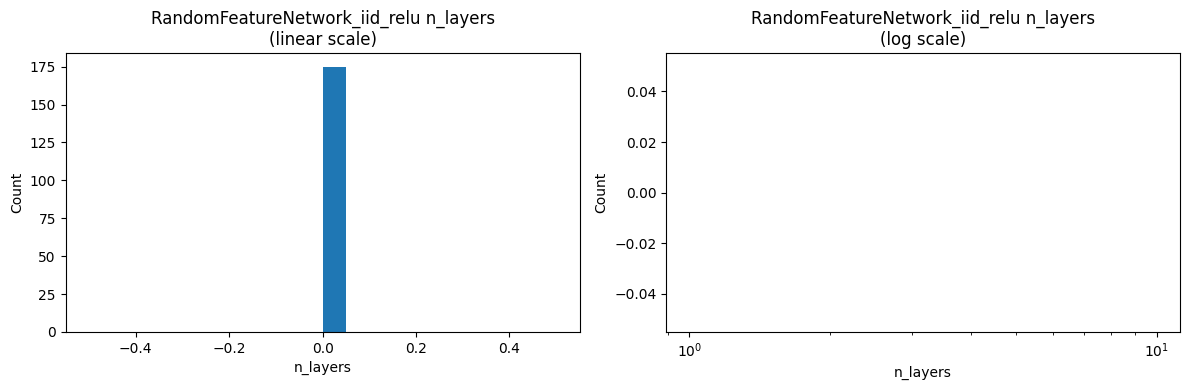

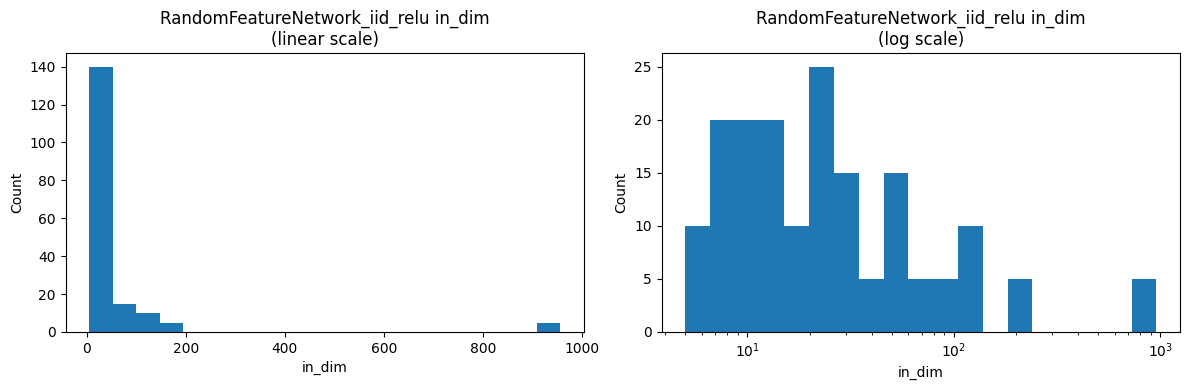

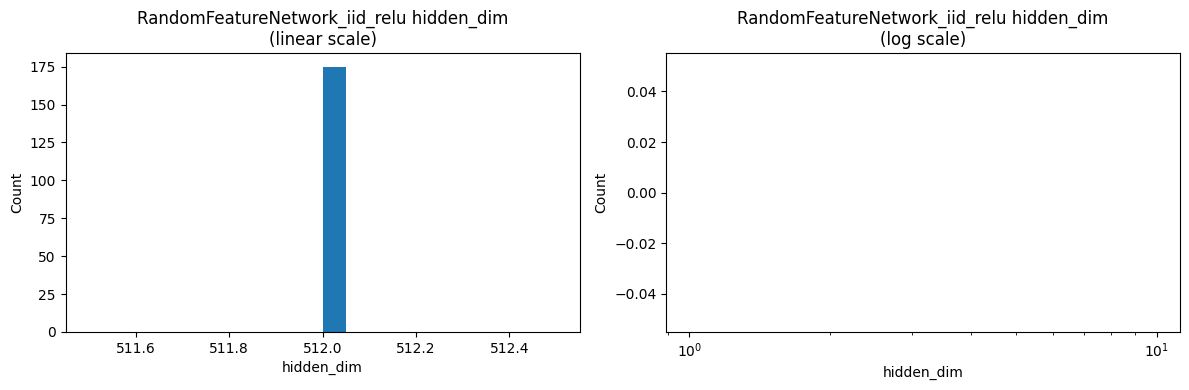

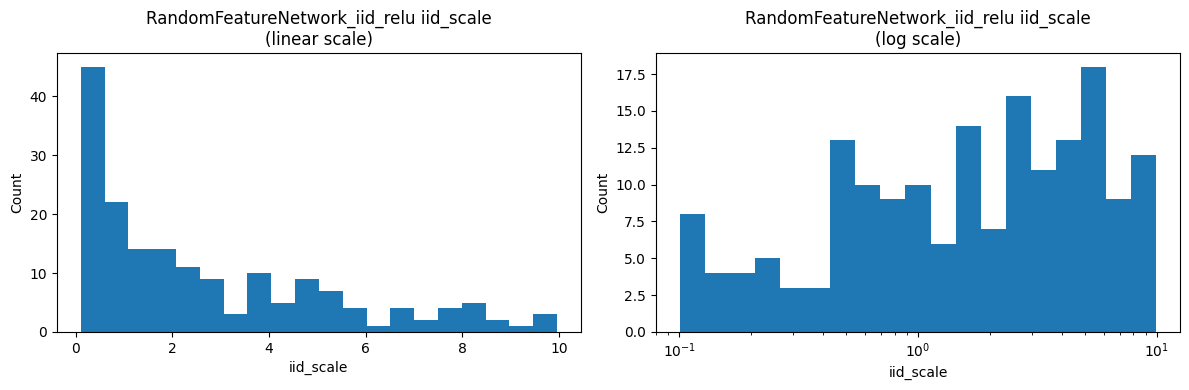

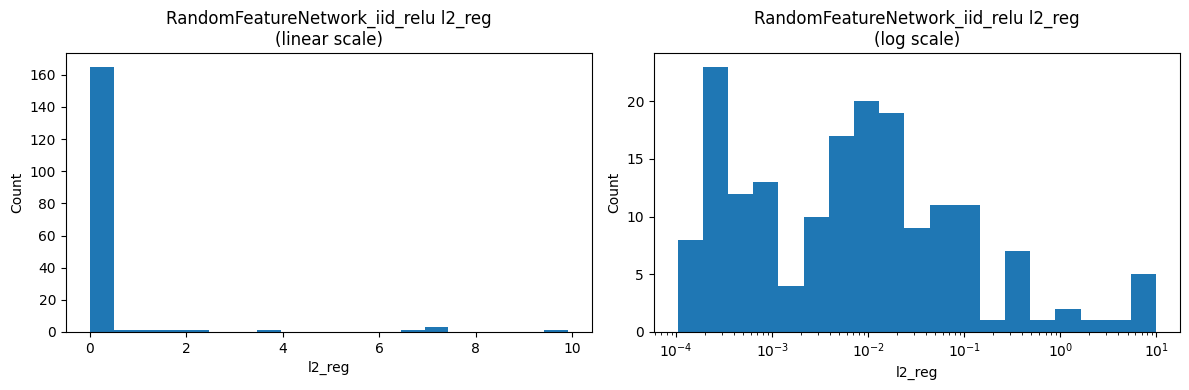

In [13]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        # save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale_type", "sandwich_solver"
                ]:
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()